In [3]:
%config Completer.use_jedi = False

# IMPORTS

In [2]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# All corrected Genes

In [40]:
refseq_corrected_by_gtex[['Gene', 'Gene_type']].drop_duplicates().to_csv('/gstock/EXOTIC/data/GENOMICS/single_multi_isoforms.csv', sep='\t', index=False)

In [13]:
refseq_corrected_by_gtex[['Gene', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     8179
Single Isoform    7173
Name: Gene_type, dtype: int64

In [55]:
refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] == 1, 'Gene_type'] = 'Single Isoform'
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1, 'Gene_type'] = 'Multi Isoform'

biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')

merge_biomart = pd.merge(refseq_corrected_by_gtex[['Gene', 'Gene_type']].drop_duplicates(), biomart[['Gene stable ID', 'Gene name', 'Gene end (bp)', 'Gene start (bp)', 'Gene type']].drop_duplicates(), left_on='Gene', right_on='Gene name')

merge_biomart

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene,Gene_type,Gene stable ID,Gene name,Gene end (bp),Gene start (bp),Gene type
0,A2M,Multi Isoform,ENSG00000175899,A2M,9116229,9067664,protein_coding
1,A2ML1,Multi Isoform,ENSG00000166535,A2ML1,8887001,8822621,protein_coding
2,A4GALT,Single Isoform,ENSG00000128274,A4GALT,42721298,42692121,protein_coding
3,A4GNT,Single Isoform,ENSG00000118017,A4GNT,138132390,138123713,protein_coding
4,AAAS,Single Isoform,ENSG00000094914,AAAS,53324864,53307456,protein_coding
...,...,...,...,...,...,...,...
16810,ZYG11B,Single Isoform,ENSG00000162378,ZYG11B,52827336,52726453,protein_coding
16811,ZYX,Multi Isoform,ENSG00000285443,ZYX,143391111,143381295,protein_coding
16812,ZYX,Multi Isoform,ENSG00000159840,ZYX,143391111,143381295,protein_coding
16813,ZZEF1,Single Isoform,ENSG00000074755,ZZEF1,4143030,4004445,protein_coding


In [14]:
merge_biomart[['Gene', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     8133
Single Isoform    7123
Name: Gene_type, dtype: int64

In [15]:
tmp_l = list()
for elem in ['Single Isoform', 'Multi Isoform']:
    biomart_tmp = merge_biomart.loc[merge_biomart['Gene_type'] == elem, 'Gene name'].unique().tolist()
    sqtl_tmp = concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['Gene name'].isin(biomart_tmp)]
    tmp_l.append({
        'Gene type' : elem,
        'Gene nb' : merge_biomart.loc[merge_biomart['Gene_type'] == elem, 'Gene name'].nunique(),
        'sGenes' : sqtl_tmp.gene_id.nunique(),
        'Ratio sGenes/Total' : round(sqtl_tmp.gene_id.nunique() / merge_biomart.loc[merge_biomart['Gene_type'] == elem, 'Gene name'].nunique(), 2),
        'sQTL' : sqtl_tmp.snpId.nunique(),
        'Ratio sQTL/sGenes' : round(sqtl_tmp.snpId.nunique() / sqtl_tmp.gene_id.nunique(), 2),
    })
    
    
pd.DataFrame(tmp_l).set_index('Gene type')

,Gene nb,sGenes,Ratio sGenes/Total,sQTL,Ratio sQTL/sGenes
Gene type,,,,,
Single Isoform,7123,2832,0.40,101728,35.92
Multi Isoform,8133,5027,0.62,206411,41.06


In [25]:
concat_df_sqtlseeker_dir_all_genes_corrected[['Gene name', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     5026
Single Isoform    2832
Name: Gene_type, dtype: int64

In [29]:
concat_df_sqtlseeker_dir_all_genes_corrected[['snpId', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     206411
Single Isoform    101728
Name: Gene_type, dtype: int64

In [46]:
merge_biomart.loc[(merge_biomart['Gene_type'] == 'Single Isoform'), 'Gene'].nunique()

7123

In [45]:

si_genes_sqtl = concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['Gene_type'] == 'Single Isoform', 'Gene'].unique().tolist()
si_genes_not_sqtl = merge_biomart.loc[(merge_biomart['Gene_type'] == 'Single Isoform') & (~merge_biomart['Gene'].isin(si_genes_sqtl)), 'Gene'].unique().tolist()
print(len(si_genes_not_sqtl))


4291

In [42]:
concat_df_sqtlseeker_dir_all_genes_corrected[['snpId']].nunique()

snpId    304044
dtype: int64

In [30]:
t = concat_df_sqtlseeker_dir_all_genes_corrected[['snpId', 'Gene_type', 'Tissue']].drop_duplicates()[['Gene_type', 'snpId']].value_counts().reset_index()
t

,Gene_type,snpId,0
0,Single Isoform,12_103947237_T_C_b38,49
1,Single Isoform,16_89502105_G_C_b38,49
2,Single Isoform,16_89504227_T_C_b38,49
3,Multi Isoform,17_5419949_C_T_b38,49
4,Multi Isoform,17_5419886_T_G_b38,49
...,...,...,...
308134,Multi Isoform,9_15943933_G_A_b38,1
308135,Multi Isoform,9_15943631_A_G_b38,1
308136,Multi Isoform,19_58406208_G_A_b38,1
308137,Multi Isoform,9_15943601_C_T_b38,1


# EXOTIC RAW


In [306]:
exotic = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_2021_corrected.parquet')
# exotic['EXOTIC_max'] = exotic.filter(regex='_exotic').apply(lambda r: max(r), axis=1)
# exotic['EXOTIC_tissue_max'] = exotic.apply(lambda r: [exotic.columns[j].replace('_exotic', '') for j, e in enumerate(r) if '_exotic' in exotic.columns[j] if e == r['EXOTIC_max']], axis=1)
# exotic['EXOTIC_tissue_max_index'] = exotic.apply(lambda r: [j for j, e in enumerate(r) if '_exotic' in exotic.columns[j] if e == r['EXOTIC_max']], axis=1)
# exotic['EXOTIC_tissue_max_len'] = exotic['EXOTIC_tissue_max'].apply(len)
# exotic['pext_tissue_max_check'] = exotic.filter(regex='pext').apply(lambda r: [j for j, e in enumerate(r)])
exotic.head(100)

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous_exotic,...,Skin - Not Sun Exposed (Suprapubic)_pextvalue,Skin - Sun Exposed (Lower leg)_pextvalue,Small Intestine - Terminal Ileum_pextvalue,Spleen_pextvalue,Stomach_pextvalue,Testis_pextvalue,Thyroid_pextvalue,Uterus_pextvalue,Vagina_pextvalue,Whole Blood_pextvalue
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.731334,...,0.57888,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.00000
1,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,1,2,A2ML1_8975778-8975961,0.69514,0.731334,...,0.57888,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.00000
2,A2ML1,ENSG00000166535,23336,8976316-8976478,0.500000,1,2,A2ML1_8976316-8976478,0.69514,0.731334,...,0.57888,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.00000
3,A2ML1,ENSG00000166535,23336,8982323-8982375,0.500000,1,2,A2ML1_8982323-8982375,0.69514,0.731334,...,0.57888,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.00000
4,A2ML1,ENSG00000166535,23336,8987258-8987278,0.500000,1,2,A2ML1_8987258-8987278,0.69514,0.731334,...,0.57888,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ABCC5,ENSG00000114770,56,183677521-183677623,0.666667,2,3,ABCC5_183677521-183677623,0.32531,0.631605,...,0.41607,0.42664,0.39387,0.40521,0.36907,0.28821,0.31591,0.31057,0.34433,0.42733
96,ABCC5,ENSG00000114770,56,183679299-183679442,0.666667,2,3,ABCC5_183679299-183679442,0.32531,0.631605,...,0.41607,0.42664,0.39387,0.40521,0.36907,0.28821,0.31591,0.31057,0.34433,0.42733
97,ABCC5,ENSG00000114770,56,183681173-183681376,0.666667,2,3,ABCC5_183681173-183681376,0.32531,0.631605,...,0.41607,0.42664,0.39387,0.40521,0.36907,0.28821,0.31591,0.31057,0.34433,0.42733
98,ABCC5,ENSG00000114770,56,183682973-183683045,0.666667,2,3,ABCC5_183682973-183683045,0.32531,0.631605,...,0.41607,0.42664,0.39387,0.40521,0.36907,0.28821,0.31591,0.31057,0.34433,0.42733


In [308]:
print(exotic.symbol.nunique())
print(exotic.MAP.nunique())

6446
27529


In [98]:
exotic_raw = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_2021_corrected.parquet')
exotic = exotic_raw.filter(regex='_exotic')
exotic.columns = [c.replace('_exotic', '') for c in exotic.columns]

pext = exotic_raw.filter(regex='_pextvalue')
pext.columns = [c.replace('_pextvalue', '') for c in pext.columns]
print(pext.columns)
check_pext_max = pext[pext >= 0.1].isna()
check_pext_min = pext[pext <= 0.9].isna()

exotic_processed = exotic_raw[['symbol', 'ensg', 'MAP', 'Exon', 'mean_proportion']]
exotic_processed['EXOTIC_max'] = exotic.apply(max, axis=1)
exotic_processed['EXOTIC_max_tissues'] = exotic.apply(lambda r: [exotic.columns[j] for j,e in enumerate(r) if e == max(r)], axis=1)
# exotic_processed['EXOTIC_max_check'] = exotic_processed.apply(lambda r: [True if pext.loc[r.name][c] >= 0.1 else False for c in r['EXOTIC_max_tissues'] ], axis=1)
exotic_processed['EXOTIC_max_pext_associated'] = exotic_processed.apply(lambda r: [pext.loc[r.name][c] for c in r['EXOTIC_max_tissues'] ], axis=1)
exotic_processed['EXOTIC_max_check_pext'] = exotic_processed.apply(lambda r: [True if pext.loc[r.name][c] > 0.1 else False for c in r['EXOTIC_max_tissues'] ], axis=1)
exotic_processed['EXOTIC_max_tissues_corrected'] = exotic_processed.apply(lambda r: [t for t,check in zip(r['EXOTIC_max_tissues'], r['EXOTIC_max_check_pext']) if check is True], axis=1)
exotic_processed['EXOTIC_tissues_nb'] = exotic_processed['EXOTIC_max_tissues_corrected'].apply(len)
exotic_processed = exotic_processed.query('EXOTIC_tissues_nb > 0')


exotic_processed['EXOTIC_min'] = exotic.apply(min, axis=1)
exotic_processed['EXOTIC_min_tissues'] = exotic.apply(lambda r: [exotic.columns[j] for j,e in enumerate(r) if e == min(r)], axis=1)
# exotic_processed['EXOTIC_max_check'] = exotic_processed.apply(lambda r: [True if pext.loc[r.name][c] >= 0.1 else False for c in r['EXOTIC_max_tissues'] ], axis=1)
exotic_processed['EXOTIC_min_pext_associated'] = exotic_processed.apply(lambda r: [pext.loc[r.name][c] for c in r['EXOTIC_min_tissues'] ], axis=1)
exotic_processed['EXOTIC_min_check_pext'] = exotic_processed.apply(lambda r: [True if pext.loc[r.name][c] < 0.9 else False for c in r['EXOTIC_min_tissues'] ], axis=1)
exotic_processed['EXOTIC_min_tissues_corrected'] = exotic_processed.apply(lambda r: [t for t,check in zip(r['EXOTIC_min_tissues'], r['EXOTIC_min_check_pext']) if check is True], axis=1)
exotic_processed['EXOTIC_tissues_nb'] = exotic_processed['EXOTIC_min_tissues_corrected'].apply(len)
exotic_processed = exotic_processed.query('EXOTIC_tissues_nb > 0')

exotic_processed
# exotic_processed_lite = exotic_processed[['symbol', 'ensg', 'MAP', 'Exon', 'mean_proportion', 'EXOTIC_min', 'EXOTIC_min_tissues_corrected']].explode('EXOTIC_min_tissues_corrected')
# exotic_processed_lite


Index(['Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)',
       'Adrenal Gland', 'Artery - Aorta', 'Artery - Coronary',
       'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes',
       'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esophagus - Muscularis', 'Fallopian Tube',
       'Heart - Atrial Appendage', 'Heart - Left Ventricle', 'Kidney 

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_max,EXOTIC_max_tissues,EXOTIC_max_pext_associated,EXOTIC_max_check_pext,EXOTIC_max_tissues_corrected,EXOTIC_tissues_nb,EXOTIC_min,EXOTIC_min_tissues,EXOTIC_min_pext_associated,EXOTIC_min_check_pext,EXOTIC_min_tissues_corrected
0,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",1,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere]
1,A2ML1,ENSG00000166535,A2ML1_8975778-8975961,8975778-8975961,0.69514,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",1,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere]
2,A2ML1,ENSG00000166535,A2ML1_8976316-8976478,8976316-8976478,0.69514,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",1,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere]
3,A2ML1,ENSG00000166535,A2ML1_8982323-8982375,8982323-8982375,0.69514,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",1,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere]
4,A2ML1,ENSG00000166535,A2ML1_8987258-8987278,8987258-8987278,0.69514,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",1,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27533,ZXDC,ENSG00000070476,ZXDC_126158475-126158570,126158475-126158570,0.20989,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)]
27534,ZXDC,ENSG00000070476,ZXDC_126160608-126160789,126160608-126160789,0.20989,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)]
27535,ZXDC,ENSG00000070476,ZXDC_126178496-126178580,126178496-126178580,0.20989,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)]
27536,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.910061,[Artery - Tibial],[0.52384],[True],[Artery - Tibial],1,0.139039,[Whole Blood],[0.20951999999999998],[True],[Whole Blood]


In [316]:
exotic

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,0.731334,0.731334,0.731334,0.731334,0.731334,0.731334,0.486061,0.252556,0.239279,0.239806,...,0.405672,0.380059,0.731334,0.731334,0.731334,0.166456,0.731334,0.298339,0.496355,0.731334
1,0.731334,0.731334,0.731334,0.731334,0.731334,0.731334,0.486061,0.252556,0.239279,0.239806,...,0.405672,0.380059,0.731334,0.731334,0.731334,0.166456,0.731334,0.298339,0.496355,0.731334
2,0.731334,0.731334,0.731334,0.731334,0.731334,0.731334,0.486061,0.252556,0.239279,0.239806,...,0.405672,0.380059,0.731334,0.731334,0.731334,0.166456,0.731334,0.298339,0.496355,0.731334
3,0.731334,0.731334,0.731334,0.731334,0.731334,0.731334,0.486061,0.252556,0.239279,0.239806,...,0.405672,0.380059,0.731334,0.731334,0.731334,0.166456,0.731334,0.298339,0.496355,0.731334
4,0.731334,0.731334,0.731334,0.731334,0.731334,0.731334,0.486061,0.252556,0.239279,0.239806,...,0.405672,0.380059,0.731334,0.731334,0.731334,0.166456,0.731334,0.298339,0.496355,0.731334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.631605,0.642835,0.412578,0.562832,0.630048,0.664204,0.683724,0.136629,0.260993,0.542684,...,0.814516,0.839155,0.753562,0.786268,0.671149,0.353230,0.461755,0.440203,0.576898,0.840667
96,0.631605,0.642835,0.412578,0.562832,0.630048,0.664204,0.683724,0.136629,0.260993,0.542684,...,0.814516,0.839155,0.753562,0.786268,0.671149,0.353230,0.461755,0.440203,0.576898,0.840667
97,0.631605,0.642835,0.412578,0.562832,0.630048,0.664204,0.683724,0.136629,0.260993,0.542684,...,0.814516,0.839155,0.753562,0.786268,0.671149,0.353230,0.461755,0.440203,0.576898,0.840667
98,0.631605,0.642835,0.412578,0.562832,0.630048,0.664204,0.683724,0.136629,0.260993,0.542684,...,0.814516,0.839155,0.753562,0.786268,0.671149,0.353230,0.461755,0.440203,0.576898,0.840667


In [61]:
# TEST
exotic_raw = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_2021_corrected.parquet')
exotic = exotic_raw.filter(regex='_exotic')
exotic.columns = [c.replace('_exotic', '') for c in exotic.columns]

pext = exotic_raw.filter(regex='_pextvalue')
pext.columns = [c.replace('_pextvalue', '') for c in pext.columns]
print(pext.columns)
check_pext = pext[pext >= 0.1].isna()

exotic_processed = exotic_raw[['symbol', 'ensg', 'MAP', 'Exon', 'mean_proportion']]
exotic_processed['EXOTIC_median'] = exotic.apply(np.median, axis=1)

for stat in [min, max]:
    str_stat = stat.__name__
    exotic_processed['EXOTIC_{}'.format(str_stat)] = exotic.apply(stat, axis=1)
    # exotic_processed['EXOTIC_min'] = exotic.apply(min, axis=1)
    # exotic_processed['EXOTIC_mean'] = exotic.apply(np.mean, axis=1)

    
    # exotic_processed['EXOTIC_max_check'] = exotic_processed.apply(lambda r: [True if pext.loc[r.name][c] >= 0.1 else False for c in r['EXOTIC_max_tissues'] ], axis=1)
    
    if str_stat == 'max':
        exotic_processed['EXOTIC_tissues_{}'.format(str_stat)] = exotic.apply(lambda r: [exotic.columns[j] for j,e in enumerate(r) if e == stat(r)], axis=1)
        exotic_processed['EXOTIC_pext_associated_{}'.format(str_stat)] = exotic_processed.apply(lambda r: [pext.loc[r.name][c] for c in r['EXOTIC_tissues_{}'.format(str_stat)] ], axis=1)
        exotic_processed['EXOTIC_check_pext_{}'.format(str_stat)] = exotic_processed.apply(lambda r: [True if pext.loc[r.name][c] > 0.1 else False for c in r['EXOTIC_tissues_{}'.format(str_stat)] ], axis=1)
    elif str_stat == 'min':
        exotic_processed['EXOTIC_tissues_{}'.format(str_stat)] = exotic.apply(lambda r: [exotic.columns[j] for j,e in enumerate(r) if e == stat(r)], axis=1)
        exotic_processed['EXOTIC_pext_associated_{}'.format(str_stat)] = exotic_processed.apply(lambda r: [pext.loc[r.name][c] for c in r['EXOTIC_tissues_{}'.format(str_stat)] ], axis=1)
        exotic_processed['EXOTIC_check_pext_{}'.format(str_stat)] = exotic_processed.apply(lambda r: [True if pext.loc[r.name][c] < 0.9 else False for c in r['EXOTIC_tissues_{}'.format(str_stat)] ], axis=1)
    exotic_processed['EXOTIC_tissues_corrected_{}'.format(str_stat)] = exotic_processed.apply(lambda r: [t for t,check in zip(r['EXOTIC_tissues_{}'.format(str_stat)], r['EXOTIC_check_pext_{}'.format(str_stat)]) if check is True], axis=1)
    exotic_processed['EXOTIC_tissues_nb_{}'.format(str_stat)] = exotic_processed['EXOTIC_tissues_corrected_{}'.format(str_stat)].apply(len)
    exotic_processed = exotic_processed[exotic_processed['EXOTIC_tissues_nb_{}'.format(str_stat)] > 0]

# exotic_processed = exotic_processed.query('EXOTIC_tissues_nb > 0')
# exotic_processed_lite = exotic_processed[['symbol', 'ensg', 'MAP', 'Exon', 'mean_proportion', 'EXOTIC_max', 'EXOTIC_max_tissues_corrected']].explode('EXOTIC_max_tissues_corrected')
# exotic_processed_lite



exotic_processed

Index(['Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)',
       'Adrenal Gland', 'Artery - Aorta', 'Artery - Coronary',
       'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes',
       'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esophagus - Muscularis', 'Fallopian Tube',
       'Heart - Atrial Appendage', 'Heart - Left Ventricle', 'Kidney 

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_median,EXOTIC_min,EXOTIC_tissues_min,EXOTIC_pext_associated_min,EXOTIC_check_pext_min,EXOTIC_tissues_corrected_min,EXOTIC_tissues_nb_min,EXOTIC_max,EXOTIC_tissues_max,EXOTIC_pext_associated_max,EXOTIC_check_pext_max,EXOTIC_tissues_corrected_max,EXOTIC_tissues_nb_max
0,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
1,A2ML1,ENSG00000166535,A2ML1_8975778-8975961,8975778-8975961,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
2,A2ML1,ENSG00000166535,A2ML1_8976316-8976478,8976316-8976478,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
3,A2ML1,ENSG00000166535,A2ML1_8982323-8982375,8982323-8982375,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
4,A2ML1,ENSG00000166535,A2ML1_8987258-8987278,8987258-8987278,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27533,ZXDC,ENSG00000070476,ZXDC_126158475-126158570,126158475-126158570,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27534,ZXDC,ENSG00000070476,ZXDC_126160608-126160789,126160608-126160789,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27535,ZXDC,ENSG00000070476,ZXDC_126178496-126178580,126178496-126178580,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27536,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.462758,0.139039,[Whole Blood],[0.20951999999999998],[True],[Whole Blood],1,0.910061,[Artery - Tibial],[0.52384],[True],[Artery - Tibial],1


In [329]:
print(pext.shape)
print(pext.shape)

(27538, 53)


In [340]:
pext.loc[446]

Adipose - Subcutaneous          0.000000
Adipose - Visceral (Omentum)    0.000000
Adrenal Gland                   0.000000
Artery - Aorta                  0.000000
Artery - Coronary               0.000000
                                  ...   
Testis                          0.000943
Thyroid                         0.000000
Uterus                          0.000000
Vagina                          0.000000
Whole Blood                     0.000000
Name: 446, Length: 53, dtype: float64

In [339]:
exotic.loc[446]

Adipose - Subcutaneous          0.465387
Adipose - Visceral (Omentum)    0.465387
Adrenal Gland                   0.465387
Artery - Aorta                  0.465387
Artery - Coronary               0.465387
                                  ...   
Testis                          0.999262
Thyroid                         0.465387
Uterus                          0.465387
Vagina                          0.465387
Whole Blood                     0.465387
Name: 446, Length: 53, dtype: float64

In [374]:
exotic_processed.loc[(exotic_processed['EXOTIC_max'] > 0.95) & (exotic_processed['EXOTIC_min'] < 0.05)]

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_median,EXOTIC_min,EXOTIC_tissues_min,EXOTIC_pext_associated_min,EXOTIC_check_pext_min,EXOTIC_tissues_corrected_min,EXOTIC_tissues_nb_min,EXOTIC_max,EXOTIC_tissues_max,EXOTIC_pext_associated_max,EXOTIC_check_pext_max,EXOTIC_tissues_corrected_max,EXOTIC_tissues_nb_max
267,ABI3,ENSG00000108798,ABI3_47293893-47294042,47293893-47294042,0.73471,NaN,0.026096,[Whole Blood],[0.58725],[True],[Whole Blood],1,0.958823,[Cervix - Endocervix],[0.8629600000000001],[True],[Cervix - Endocervix],1
577,ADAMTS13,ENSG00000160323,ADAMTS13_136295152-136295221,136295152-136295221,0.19153,0.535304,0.021546,[Whole Blood],[0.0],[True],[Whole Blood],1,0.955107,[Fallopian Tube],[0.345],[True],[Fallopian Tube],1
578,ADAMTS13,ENSG00000160323,ADAMTS13_136320407-136320557,136320407-136320557,0.19153,0.535304,0.021546,[Whole Blood],[0.0],[True],[Whole Blood],1,0.955107,[Fallopian Tube],[0.345],[True],[Fallopian Tube],1
1306,ANKHD1,ENSG00000131503,ANKHD1_139862165-139862252,139862165-139862252,0.19276,0.469795,0.048500,[Whole Blood],[0.091075],[True],[Whole Blood],1,0.979180,[Cells - Cultured fibroblasts],[0.32432],[True],[Cells - Cultured fibroblasts],1
1307,ANKHD1,ENSG00000131503,ANKHD1_139864706-139864833,139864706-139864833,0.19276,0.469795,0.048500,[Whole Blood],[0.091075],[True],[Whole Blood],1,0.979180,[Cells - Cultured fibroblasts],[0.32432],[True],[Cells - Cultured fibroblasts],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26983,ZNF23,ENSG00000167377,ZNF23_71487945-71487978,71487945-71487978,0.28673,0.488932,0.029354,[Whole Blood],[0.10417],[True],[Whole Blood],1,0.963899,[Pituitary],[0.45813000000000004],[True],[Pituitary],1
27067,ZNF326,ENSG00000162664,ZNF326_90473171-90473309,90473171-90473309,0.54856,0.512060,0.033418,[Brain - Spinal cord (cervical c-1)],[0.35764],[True],[Brain - Spinal cord (cervical c-1)],1,0.972077,[Whole Blood],[0.75],[True],[Whole Blood],1
27314,ZNF584,ENSG00000171574,ZNF584_58920515-58920532,58920515-58920532,0.35499,0.500124,0.008632,[Whole Blood],[0.0],[True],[Whole Blood],1,0.961504,[Cervix - Endocervix],[0.5958100000000001],[True],[Cervix - Endocervix],1
27343,ZNF618,ENSG00000157657,ZNF618_116778393-116778452,116778393-116778452,0.89245,0.493106,0.043249,[Testis],[0.78552],[True],[Testis],1,0.957482,"[Cells - EBV-transformed lymphocytes, Whole Bl...","[1.0, 1.0]","[True, True]","[Cells - EBV-transformed lymphocytes, Whole Bl...",2


In [342]:
exotic_processed.loc[exotic_processed['EXOTIC_max'] > 0.999]

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_max,EXOTIC_max_tissues,EXOTIC_max_pext_associated,EXOTIC_max_check_pext,EXOTIC_max_tissues_corrected,EXOTIC_tissues_nb
542,ADAMTS10,ENSG00000142303,ADAMTS10_8654336-8654458,8654336-8654458,0.272060,0.999120,[Cells - EBV-transformed lymphocytes],[1.0],[True],[Cells - EBV-transformed lymphocytes],1
543,ADAMTS10,ENSG00000142303,ADAMTS10_8656842-8656987,8656842-8656987,0.272060,0.999120,[Cells - EBV-transformed lymphocytes],[1.0],[True],[Cells - EBV-transformed lymphocytes],1
638,ADAT1,ENSG00000065457,ADAT1_75646141-75646736,75646141-75646736,0.044625,0.999111,[Testis],[0.41908999999999996],[True],[Testis],1
948,AKAP12,ENSG00000131016,AKAP12_151662918-151662921,151662918-151662921,0.007762,0.999013,[Testis],[0.28836999999999996],[True],[Testis],1
1614,AP2S1,ENSG00000042753,AP2S1_47353913-47353921,47353913-47353921,0.004785,0.999260,[Testis],[0.24074],[True],[Testis],1
...,...,...,...,...,...,...,...,...,...,...,...
21308,SLC25A46,ENSG00000164209,SLC25A46_110073939-110073948,110073939-110073948,0.006423,0.999262,[Testis],[0.34043],[True],[Testis],1
21398,SLC35E4,ENSG00000100036,SLC35E4_31061480-31061544,31061480-31061544,0.046896,0.999230,[Testis],[0.9643700000000001],[True],[Testis],1
21482,SLC41A3,ENSG00000114544,SLC41A3_125775201-125775395,125775201-125775395,0.007641,0.999033,[Testis],[0.24969],[True],[Testis],1
23029,SYPL1,ENSG00000008282,SYPL1_105752925-105752975,105752925-105752975,0.035341,0.999203,[Testis],[0.6814899999999999],[True],[Testis],1


In [379]:
exotic_processed.loc[exotic_processed['EXOTIC_max'] > 0.9, 'MAP'].nunique()

12577

In [360]:
exotic.loc[851].to_dict()

{'Adipose - Subcutaneous': 0.6912684559648886,
 'Adipose - Visceral (Omentum)': 0.6504588354479091,
 'Adrenal Gland': 0.5251327866237987,
 'Artery - Aorta': 0.6139386520044104,
 'Artery - Coronary': 0.5890950810710047,
 'Artery - Tibial': 0.6200273515836586,
 'Bladder': 0.5169354826142328,
 'Brain - Amygdala': 0.4599103833210229,
 'Brain - Anterior cingulate cortex (BA24)': 0.40356322927269156,
 'Brain - Caudate (basal ganglia)': 0.4179258804706584,
 'Brain - Cerebellar Hemisphere': 0.43560869163433485,
 'Brain - Cerebellum': 0.4778196797301099,
 'Brain - Cortex': 0.5582251694558402,
 'Brain - Frontal Cortex (BA9)': 0.4688093890794189,
 'Brain - Hippocampus': 0.4325789485568542,
 'Brain - Hypothalamus': 0.41108023575648184,
 'Brain - Nucleus accumbens (basal ganglia)': 0.4155810286722139,
 'Brain - Putamen (basal ganglia)': 0.3191970955967621,
 'Brain - Spinal cord (cervical c-1)': 0.5528582993607807,
 'Brain - Substantia nigra': 0.32434025293361335,
 'Breast - Mammary Tissue': 0.64006

In [363]:
pext.loc[984].to_dict()

{'Adipose - Subcutaneous': 0.9367700000000001,
 'Adipose - Visceral (Omentum)': 0.95275,
 'Adrenal Gland': 0.9643799999999999,
 'Artery - Aorta': 0.94965,
 'Artery - Coronary': 0.94465,
 'Artery - Tibial': 0.9416200000000001,
 'Bladder': 0.94632,
 'Brain - Amygdala': 0.9798,
 'Brain - Anterior cingulate cortex (BA24)': 0.9643700000000001,
 'Brain - Caudate (basal ganglia)': 0.9757299999999999,
 'Brain - Cerebellar Hemisphere': 1.0,
 'Brain - Cerebellum': 1.0,
 'Brain - Cortex': 0.97216,
 'Brain - Frontal Cortex (BA9)': 0.9667399999999999,
 'Brain - Hippocampus': 0.97419,
 'Brain - Hypothalamus': 0.98235,
 'Brain - Nucleus accumbens (basal ganglia)': 0.96583,
 'Brain - Putamen (basal ganglia)': 0.97593,
 'Brain - Spinal cord (cervical c-1)': 0.9916,
 'Brain - Substantia nigra': 0.9901399999999999,
 'Breast - Mammary Tissue': 0.9349700000000001,
 'Cells - Cultured fibroblasts': 0.96268,
 'Cells - EBV-transformed lymphocytes': 1.0,
 'Cervix - Ectocervix': 0.90856,
 'Cervix - Endocervix': 

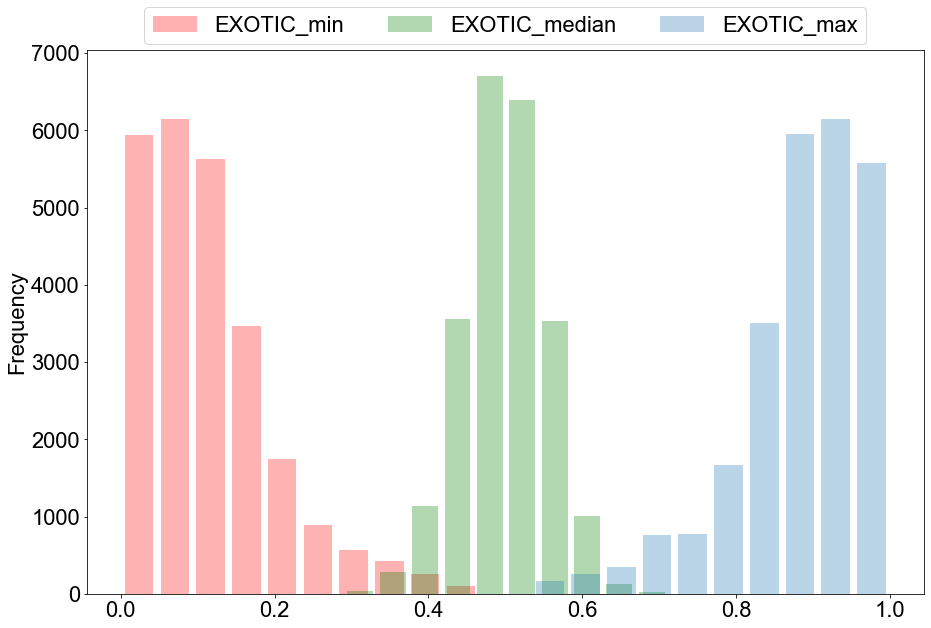

In [27]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
exotic_processed.EXOTIC_min.plot.hist(alpha=0.3, color='r', rwidth=0.8)
exotic_processed.EXOTIC_median.plot.hist(alpha=0.3, color='g', rwidth=0.8)
exotic_processed.EXOTIC_max.plot.hist(alpha=0.3, rwidth=0.8)

legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3)
# print(legend.text)

In [41]:
exotic_processed

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_median,EXOTIC_min,EXOTIC_tissues_min,EXOTIC_pext_associated_min,EXOTIC_check_pext_min,EXOTIC_tissues_corrected_min,EXOTIC_tissues_nb_min,EXOTIC_max,EXOTIC_tissues_max,EXOTIC_pext_associated_max,EXOTIC_check_pext_max,EXOTIC_tissues_corrected_max,EXOTIC_tissues_nb_max
0,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
1,A2ML1,ENSG00000166535,A2ML1_8975778-8975961,8975778-8975961,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
2,A2ML1,ENSG00000166535,A2ML1_8976316-8976478,8976316-8976478,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
3,A2ML1,ENSG00000166535,A2ML1_8982323-8982375,8982323-8982375,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
4,A2ML1,ENSG00000166535,A2ML1_8987258-8987278,8987258-8987278,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27533,ZXDC,ENSG00000070476,ZXDC_126158475-126158570,126158475-126158570,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27534,ZXDC,ENSG00000070476,ZXDC_126160608-126160789,126160608-126160789,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27535,ZXDC,ENSG00000070476,ZXDC_126178496-126178580,126178496-126178580,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27536,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.462758,0.139039,[Whole Blood],[0.20951999999999998],[True],[Whole Blood],1,0.910061,[Artery - Tibial],[0.52384],[True],[Artery - Tibial],1


In [50]:
exotic_processed.loc[exotic_processed['EXOTIC_max'] > 0.9].explode('EXOTIC_tissues_max')[['EXOTIC_tissues_max', 'EXOTIC_max', 'symbol', 'MAP']]

,EXOTIC_tissues_max,EXOTIC_max,symbol,MAP
12,Uterus,0.931102,A2ML1,A2ML1_8997768-8997770
13,Cells - Cultured fibroblasts,0.904125,A2M,A2M_9264755-9264787
14,Cells - Cultured fibroblasts,0.904125,A2M,A2M_9264973-9265102
15,Cells - Cultured fibroblasts,0.904125,A2M,A2M_9265956-9266139
16,Cells - Cultured fibroblasts,0.904125,A2M,A2M_9268360-9268445
...,...,...,...,...
27532,Muscle - Skeletal,0.912582,ZXDC,ZXDC_126157218-126157304
27533,Muscle - Skeletal,0.912582,ZXDC,ZXDC_126158475-126158570
27534,Muscle - Skeletal,0.912582,ZXDC,ZXDC_126160608-126160789
27535,Muscle - Skeletal,0.912582,ZXDC,ZXDC_126178496-126178580


In [51]:
exotic_processed.loc[exotic_processed['EXOTIC_max'] > 0.9].explode('EXOTIC_tissues_max')[['EXOTIC_tissues_max', 'EXOTIC_max', 'symbol', 'MAP']].to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_max_Rdata.xlsx', index=False)

In [52]:
exotic_processed.loc[exotic_processed['EXOTIC_min'] < 0.1].explode('EXOTIC_tissues_min')[['EXOTIC_tissues_min', 'EXOTIC_min', 'symbol', 'MAP']].to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_min_Rdata.xlsx', index=False)

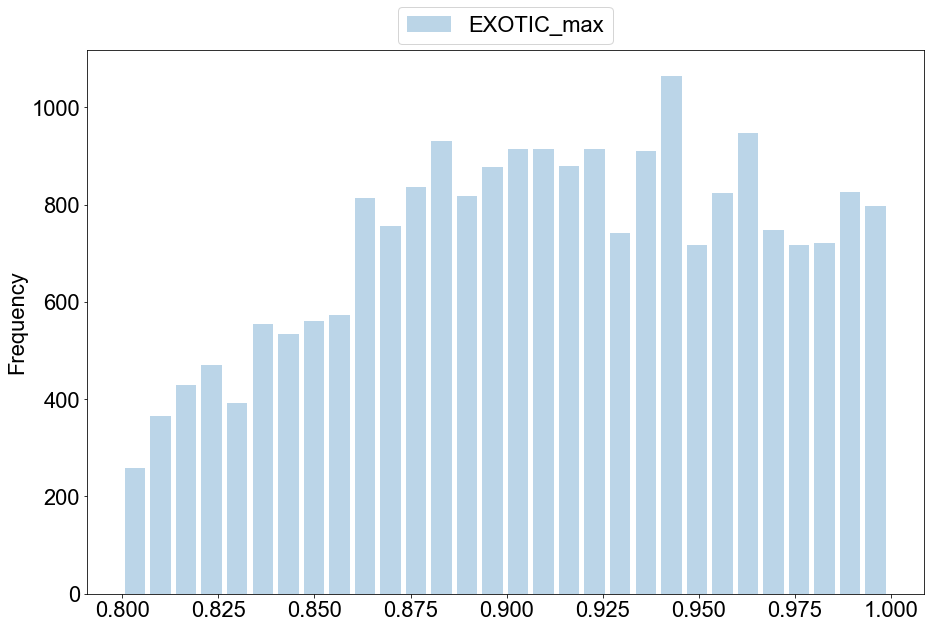

In [38]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
exotic_processed.loc[exotic_processed['EXOTIC_max'] > 0.8].EXOTIC_max.plot.hist(alpha=0.3, rwidth=0.8, bins=30)

legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3)
# print(legend.text)

In [30]:
exotic_processed

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_median,EXOTIC_min,EXOTIC_tissues_min,EXOTIC_pext_associated_min,EXOTIC_check_pext_min,EXOTIC_tissues_corrected_min,EXOTIC_tissues_nb_min,EXOTIC_max,EXOTIC_tissues_max,EXOTIC_pext_associated_max,EXOTIC_check_pext_max,EXOTIC_tissues_corrected_max,EXOTIC_tissues_nb_max
0,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
1,A2ML1,ENSG00000166535,A2ML1_8975778-8975961,8975778-8975961,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
2,A2ML1,ENSG00000166535,A2ML1_8976316-8976478,8976316-8976478,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
3,A2ML1,ENSG00000166535,A2ML1_8982323-8982375,8982323-8982375,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
4,A2ML1,ENSG00000166535,A2ML1_8987258-8987278,8987258-8987278,0.69514,0.496355,0.153430,[Brain - Cerebellar Hemisphere],[0.17518],[True],[Brain - Cerebellar Hemisphere],1,0.731334,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru...","[Adipose - Subcutaneous, Adipose - Visceral (O...",24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27533,ZXDC,ENSG00000070476,ZXDC_126158475-126158570,126158475-126158570,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27534,ZXDC,ENSG00000070476,ZXDC_126160608-126160789,126160608-126160789,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27535,ZXDC,ENSG00000070476,ZXDC_126178496-126178580,126178496-126178580,0.20989,0.509851,0.150855,[Brain - Nucleus accumbens (basal ganglia)],[0.11398],[True],[Brain - Nucleus accumbens (basal ganglia)],1,0.912582,[Muscle - Skeletal],[0.34009],[True],[Muscle - Skeletal],1
27536,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.462758,0.139039,[Whole Blood],[0.20951999999999998],[True],[Whole Blood],1,0.910061,[Artery - Tibial],[0.52384],[True],[Artery - Tibial],1


In [17]:
exotic.symbol.nunique()

6446

In [280]:
bins = np.arange(0.5,1.02,0.02)
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
labels_ratio

['0.5 - 0.52',
 '0.52 - 0.54',
 '0.54 - 0.56',
 '0.56 - 0.58',
 '0.58 - 0.6',
 '0.6 - 0.62',
 '0.62 - 0.64',
 '0.64 - 0.66',
 '0.66 - 0.68',
 '0.68 - 0.7',
 '0.7 - 0.72',
 '0.72 - 0.74',
 '0.74 - 0.76',
 '0.76 - 0.78',
 '0.78 - 0.8',
 '0.8 - 0.82',
 '0.82 - 0.84',
 '0.84 - 0.86',
 '0.86 - 0.88',
 '0.88 - 0.9',
 '0.9 - 0.92',
 '0.92 - 0.94',
 '0.94 - 0.96',
 '0.96 - 0.98',
 '0.98 - 1.0']

In [93]:
exotic_processed

,EXOTIC_bins,Tissue,snpId,MAP,Ratio_Exon_sQTL,EXOTIC_bin_start,snpId_total,MAP_total,Ratio_Exon_sQTL_total,Group,Enrichment,Ratio_sQTL
0,0.06 - 0.08,Testis,2914.0,64.0,45.531250,0.06,26896.0,533.0,50.461538,Group1,0.902296,0.108343
1,0.2 - 0.22,Testis,145.0,15.0,9.666667,0.2,18386.0,206.0,89.252427,Group1,0.108307,0.007886
2,0.38 - 0.4,Testis,237.0,6.0,39.500000,0.38,23416.0,38.0,616.210526,Group1,0.064101,0.010121
3,0.12 - 0.14,Testis,1549.0,36.0,43.027778,0.12,29676.0,514.0,57.735409,Group1,0.745258,0.052197
4,0.04 - 0.06,Testis,5566.0,99.0,56.222222,0.04,32963.0,652.0,50.556748,Group1,1.112062,0.168856
...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.1 - 0.12,Kidney - Cortex,14.0,3.0,4.666667,0.1,1219.0,67.0,18.194030,Group4,0.256494,0.011485
746,0.3 - 0.32,Kidney - Cortex,4.0,2.0,2.000000,0.3,104.0,13.0,8.000000,Group4,0.250000,0.038462
747,0.2 - 0.22,Kidney - Cortex,37.0,1.0,37.000000,0.2,478.0,26.0,18.384615,Group4,2.012552,0.077406
748,0.12 - 0.14,Kidney - Cortex,12.0,1.0,12.000000,0.12,1244.0,49.0,25.387755,Group4,0.472669,0.009646


In [117]:
# exotic_processed = pd.read_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_tissues_Rdata_final_min.parquet')
# exotic_processed = exotic_processed.reset_index()
# exotic_processed_lite = exotic_processed[['symbol', 'ensg', 'MAP', 'Exon', 'mean_proportion', 'EXOTIC_min', 'EXOTIC_min_tissues_corrected']].explode('EXOTIC_min_tissues_corrected')
# exotic_processed_lite
# merge_exotic_sqtl = pd.merge(exotic_processed_lite, concat_df_sqtlseeker_dir_all_genes_corrected, left_on=['ensg'], right_on=['gene_id'])
# merge_exotic_sqtl

bins = np.arange(0,0.5,0.05)
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
merge_exotic_sqtl["EXOTIC_bins"] = pd.cut(merge_exotic_sqtl["EXOTIC_min"], bins=bins, labels=labels_ratio, include_lowest=True)

# merge_exotic_sqtl[['MAP', 'snpId']].sort_values(by=['MAP', 'snpId']).head()


In [106]:
merge_exotic_sqtl

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_min,EXOTIC_min_tissues_corrected,Gene,Gene_type,Gene stable ID,...,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perm,pv.emp.perm,EXOTIC_bins
0,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.153430,Brain - Cerebellar Hemisphere,A2ML1,Multi Isoform,ENSG00000166535,...,4.243590e-05,0.717553,10100,0.487278,0.831543,Testis,ENSG00000166535,1000.0,0.000999,0.14 - 0.16
1,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.153430,Brain - Cerebellar Hemisphere,A2ML1,Multi Isoform,ENSG00000166535,...,4.048782e-05,2.863344,10100,0.061974,0.441276,Skin - Not Sun Exposed (Suprapubic),ENSG00000166535,1000.0,0.000999,0.14 - 0.16
2,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.153430,Brain - Cerebellar Hemisphere,A2ML1,Multi Isoform,ENSG00000166535,...,6.481461e-05,0.597191,10100,0.549154,0.859452,Testis,ENSG00000166535,1000.0,0.000999,0.14 - 0.16
3,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.153430,Brain - Cerebellar Hemisphere,A2ML1,Multi Isoform,ENSG00000166535,...,7.053769e-06,0.427436,10100,0.654886,0.901886,Skin - Not Sun Exposed (Suprapubic),ENSG00000166535,1000.0,0.000999,0.14 - 0.16
4,A2ML1,ENSG00000166535,A2ML1_8975248-8975309,8975248-8975309,0.69514,0.153430,Brain - Cerebellar Hemisphere,A2ML1,Multi Isoform,ENSG00000166535,...,1.834738e-07,1.240273,10100,0.286704,0.718208,Testis,ENSG00000166535,1000.0,0.000999,0.14 - 0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11155039,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.139039,Whole Blood,ZXDC,Multi Isoform,ENSG00000070476,...,8.162518e-06,6.856383,10100,0.001485,0.153711,Brain - Putamen (basal ganglia),ENSG00000070476,1000.0,0.000999,0.12 - 0.14
11155040,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.139039,Whole Blood,ZXDC,Multi Isoform,ENSG00000070476,...,8.162518e-06,6.856383,10100,0.001485,0.153711,Brain - Putamen (basal ganglia),ENSG00000070476,1000.0,0.000999,0.12 - 0.14
11155041,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.139039,Whole Blood,ZXDC,Multi Isoform,ENSG00000070476,...,8.162518e-06,6.856383,10100,0.001485,0.153711,Brain - Putamen (basal ganglia),ENSG00000070476,1000.0,0.000999,0.12 - 0.14
11155042,ZXDC,ENSG00000070476,ZXDC_126180378-126181063,126180378-126181063,0.34803,0.139039,Whole Blood,ZXDC,Multi Isoform,ENSG00000070476,...,4.235591e-06,6.167569,10100,0.001980,0.163138,Brain - Putamen (basal ganglia),ENSG00000070476,1000.0,0.000999,0.12 - 0.14


In [196]:
print(merge_exotic_sqtl.shape)
print(merge_exotic_sqtl.symbol.nunique())
print(merge_exotic_sqtl.MAP.nunique())
print(merge_exotic_sqtl.snpId.nunique())


(10590498, 44)
4037
17532
175249


In [126]:
tmp2 = pd.concat(
    [merge_exotic_sqtl[['EXOTIC_bins', 'snpId', ]].drop_duplicates().groupby(['EXOTIC_bins']).count(),
    merge_exotic_sqtl[['EXOTIC_bins', 'MAP', ]].drop_duplicates().groupby(['EXOTIC_bins']).count()],
    axis=1
)
# tmp.columns = ['MAP', 'EXOTIC_max_exon', 'Tissue', 'snpId']
tmp2['Ratio_Exon_sQTL_total'] = tmp2['snpId'] / tmp2['MAP']
# tmp2['EXOTIC_bin_start'] = labels[:-1]
# tmp.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata2.parquet')
tmp2

,snpId,MAP,Ratio_Exon_sQTL_total
EXOTIC_bins,,,
0.0 - 0.05,69857,4223,16.542032
0.05 - 0.1,72713,4399,16.529439
0.1 - 0.15,70549,3941,17.901294
0.15 - 0.2,45209,2239,20.191603
0.2 - 0.25,21553,928,23.225216
0.25 - 0.3,14353,561,25.584670
0.3 - 0.35,7907,304,26.009868
0.35 - 0.4,6974,285,24.470175
0.4 - 0.45,3115,84,37.083333


In [424]:
tmp2_tissues = pd.concat(
    [merge_exotic_sqtl[['EXOTIC_bins', 'snpId', 'Tissue' ]].groupby(['EXOTIC_bins', 'Tissue']).count(),
    merge_exotic_sqtl[['EXOTIC_bins', 'MAP', 'Tissue' ]].drop_duplicates().groupby(['EXOTIC_bins', 'Tissue']).count()],
    axis=1
)
tmp2_tissues.columns = [str(c) + '_total' for c in tmp2_tissues.columns]
# tmp.columns = ['MAP', 'EXOTIC_max_exon', 'Tissue', 'snpId']
tmp2_tissues['Ratio_Exon_sQTL_total'] = tmp2_tissues['snpId_total'] / tmp2_tissues['MAP_total']
# tmp2['EXOTIC_bin_start'] = labels[:-1]
# tmp.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata2.parquet')
tmp2_tissues

snpId_total  MAP_total  \
EXOTIC_bins Tissue                                                 
0.5 - 0.52  Adipose - Subcutaneous                NaN        NaN   
            Adipose - Visceral (Omentum)          NaN        NaN   
            Adrenal Gland                         NaN        NaN   
            Artery - Aorta                        NaN        NaN   
            Artery - Coronary                     NaN        NaN   
...                                               ...        ...   
0.98 - 1.0  Testis                            37530.0      595.0   
            Thyroid                           31494.0      642.0   
            Uterus                             6626.0      230.0   
            Vagina                             6450.0      197.0   
            Whole Blood                       11985.0      255.0   

                                          Ratio_Exon_sQTL_total  
EXOTIC_bins Tissue                                               
0.5 - 0.52  Adipose - Subcutaneous                          NaN  
            Adipose - Visceral (Omentum)                    NaN  
            Adrenal Gland                                   NaN  
            Artery - Aorta                                  NaN  
            Artery - Coronary                               NaN  
...                                                         ...  
0.98 - 1.0  Testis                                    63.075630  
            Thyroid                                   49.056075  
            Uterus                                    28.808696  
            Vagina                                    32.741117  
            Whole Blood                               47.000000  

[1225 rows x 3 columns]

In [116]:
# merge_exotic_sqtl_on_tissues = pd.merge(exotic_processed_lite, concat_df_sqtlseeker_dir_all_genes_corrected, left_on=['ensg', 'EXOTIC_min_tissues_corrected'], right_on=['gene_id', 'Tissue'])
# merge_exotic_sqtl

bins = np.arange(0,0.5,0.05)
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
merge_exotic_sqtl_on_tissues["EXOTIC_bins"] = pd.cut(merge_exotic_sqtl_on_tissues["EXOTIC_min"], bins=bins, labels=labels_ratio, include_lowest=True)
print(bins)
# merge_exotic_sqtl[['MAP', 'snpId']].sort_values(by=['MAP', 'snpId']).head()


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]


In [208]:
print(merge_exotic_sqtl_on_tissues.shape)
print(merge_exotic_sqtl_on_tissues.symbol.nunique())
print(merge_exotic_sqtl_on_tissues.MAP.nunique())
print(merge_exotic_sqtl_on_tissues.snpId.nunique())


(185991, 44)
1317
3997
48704


In [125]:
tmp = pd.concat(
    [merge_exotic_sqtl_on_tissues[['EXOTIC_bins', 'snpId']].drop_duplicates().groupby(['EXOTIC_bins']).count(),
    merge_exotic_sqtl_on_tissues[['EXOTIC_bins', 'MAP']].drop_duplicates().groupby(['EXOTIC_bins',]).count()],
    axis=1
)
# tmp.columns = ['MAP', 'EXOTIC_max_exon', 'Tissue', 'snpId']
tmp['Ratio_Exon_sQTL'] = tmp['snpId'] / tmp['MAP']
tmp = tmp.reset_index()
tmp['EXOTIC_bin_start'] = tmp['EXOTIC_bins'].apply(lambda r: r.split(' - ')[0])
tmp = tmp.set_index(['EXOTIC_bins'])
# tmp.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata2.parquet')
tmp

,snpId,MAP,Ratio_Exon_sQTL,EXOTIC_bin_start
EXOTIC_bins,,,,
0.0 - 0.05,13716,864,15.875000,0.0
0.05 - 0.1,11722,888,13.200450,0.05
0.1 - 0.15,12225,825,14.818182,0.1
0.15 - 0.2,5521,386,14.303109,0.15
0.2 - 0.25,3547,184,19.277174,0.2
0.25 - 0.3,3342,101,33.089109,0.25
0.3 - 0.35,1422,83,17.132530,0.3
0.35 - 0.4,2992,139,21.525180,0.35
0.4 - 0.45,2026,53,38.226415,0.4


In [285]:
tmp_tissues = pd.concat(
    [merge_exotic_sqtl_on_tissues[['EXOTIC_bins', 'snpId', 'Tissue']].groupby(['EXOTIC_bins', 'Tissue']).count(),
    merge_exotic_sqtl_on_tissues[['EXOTIC_bins', 'MAP', 'Tissue']].drop_duplicates().groupby(['EXOTIC_bins', 'Tissue']).count()],
    axis=1
)
# tmp.columns = ['MAP', 'EXOTIC_max_exon', 'Tissue', 'snpId']
tmp_tissues['Ratio_Exon_sQTL'] = tmp_tissues['snpId'] / tmp_tissues['MAP']
tmp_tissues = tmp_tissues.reset_index()
tmp_tissues['EXOTIC_bin_start'] = tmp_tissues['EXOTIC_bins'].apply(lambda r: r.split(' - ')[0])
tmp_tissues = tmp_tissues.set_index(['EXOTIC_bins', 'Tissue'])
# tmp.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata2.parquet')
tmp_tissues

snpId    MAP  Ratio_Exon_sQTL  \
EXOTIC_bins Tissue                                                         
0.5 - 0.52  Adipose - Subcutaneous           NaN    NaN              NaN   
            Adipose - Visceral (Omentum)     NaN    NaN              NaN   
            Adrenal Gland                    NaN    NaN              NaN   
            Artery - Aorta                   NaN    NaN              NaN   
            Artery - Coronary                NaN    NaN              NaN   
...                                          ...    ...              ...   
0.98 - 1.0  Testis                        7621.0  133.0        57.300752   
            Thyroid                          NaN    NaN              NaN   
            Uterus                           NaN    NaN              NaN   
            Vagina                           NaN    NaN              NaN   
            Whole Blood                   3098.0   68.0        45.558824   

                                         EXOTIC_bin_start  
EXOTIC_bins Tissue                                         
0.5 - 0.52  Adipose - Subcutaneous                    0.5  
            Adipose - Visceral (Omentum)              0.5  
            Adrenal Gland                             0.5  
            Artery - Aorta                            0.5  
            Artery - Coronary                         0.5  
...                                                   ...  
0.98 - 1.0  Testis                                   0.98  
            Thyroid                                  0.98  
            Uterus                                   0.98  
            Vagina                                   0.98  
            Whole Blood                              0.98  

[1225 rows x 4 columns]

In [414]:
test = tmp_tissues.reset_index()
test.loc[test['Tissue'] == 'Colon - Transverse']

,EXOTIC_bins,Tissue,snpId,MAP,Ratio_Exon_sQTL,EXOTIC_bin_start
23,0.5 - 0.52,Colon - Transverse,NaN,NaN,NaN,0.5
72,0.52 - 0.54,Colon - Transverse,198.0,6.0,33.000000,0.52
121,0.54 - 0.56,Colon - Transverse,218.0,13.0,16.769231,0.54
170,0.56 - 0.58,Colon - Transverse,37.0,4.0,9.250000,0.56
219,0.58 - 0.6,Colon - Transverse,NaN,NaN,NaN,0.58
268,0.6 - 0.62,Colon - Transverse,27.0,2.0,13.500000,0.6
317,0.62 - 0.64,Colon - Transverse,19.0,3.0,6.333333,0.62
366,0.64 - 0.66,Colon - Transverse,14.0,4.0,3.500000,0.64
415,0.66 - 0.68,Colon - Transverse,4.0,1.0,4.000000,0.66
464,0.68 - 0.7,Colon - Transverse,23.0,6.0,3.833333,0.68


In [120]:
concat_final = pd.concat([tmp, tmp2.rename({'snpId' : 'snpId_total'}, axis=1)], axis=1).dropna()
# concat_final['Enrichment'] = concat_final['Ratio_Exon_sQTL'] / concat_final['Ratio_Exon_sQTL_total']
# concat_final.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata_final.parquet')
concat_final

,snpId,MAP,EXOTIC_bin_start,snpId_total,MAP
EXOTIC_bins,,,,,
0.0 - 0.05,13716,864,0.0,69857,4223
0.05 - 0.1,11722,888,0.05,72713,4399
0.1 - 0.15,12225,825,0.1,70549,3941
0.15 - 0.2,5521,386,0.15,45209,2239
0.2 - 0.25,3547,184,0.2,21553,928
0.25 - 0.3,3342,101,0.25,14353,561
0.3 - 0.35,1422,83,0.3,7907,304
0.35 - 0.4,2992,139,0.35,6974,285
0.4 - 0.45,2026,53,0.4,3115,84


In [416]:
test = concat_final.reset_index()
test.loc[test['Tissue'] == 'Colon - Transverse']

,EXOTIC_bins,Tissue,snpId,MAP,Ratio_Exon_sQTL,EXOTIC_bin_start,Ratio_Exon_sQTL_total,Group,Enrichment
22,0.52 - 0.54,Colon - Transverse,198.0,6.0,33.000000,0.52,1704.666667,Group2,0.019359
71,0.54 - 0.56,Colon - Transverse,218.0,13.0,16.769231,0.54,816.357143,Group2,0.020542
117,0.56 - 0.58,Colon - Transverse,37.0,4.0,9.250000,0.56,422.000000,Group2,0.021919
177,0.6 - 0.62,Colon - Transverse,27.0,2.0,13.500000,0.6,403.250000,Group2,0.033478
216,0.62 - 0.64,Colon - Transverse,19.0,3.0,6.333333,0.62,428.117647,Group2,0.014793
252,0.64 - 0.66,Colon - Transverse,14.0,4.0,3.500000,0.64,373.111111,Group2,0.009381
282,0.66 - 0.68,Colon - Transverse,4.0,1.0,4.000000,0.66,199.500000,Group2,0.020050
317,0.68 - 0.7,Colon - Transverse,23.0,6.0,3.833333,0.68,253.904762,Group2,0.015098
571,0.86 - 0.88,Colon - Transverse,1.0,1.0,1.000000,0.86,42.581699,Group2,0.023484


In [417]:
test.loc[test['Tissue'] == 'Testis']

,EXOTIC_bins,Tissue,snpId,MAP,Ratio_Exon_sQTL,EXOTIC_bin_start,Ratio_Exon_sQTL_total,Group,Enrichment
43,0.52 - 0.54,Testis,64.0,2.0,32.000000,0.52,1206.100000,Group4,0.026532
91,0.54 - 0.56,Testis,18.0,3.0,6.000000,0.54,2930.714286,Group4,0.002047
135,0.56 - 0.58,Testis,9.0,2.0,4.500000,0.56,1135.166667,Group4,0.003964
191,0.6 - 0.62,Testis,117.0,2.0,58.500000,0.6,1366.500000,Group4,0.042810
233,0.62 - 0.64,Testis,36.0,3.0,12.000000,0.62,539.666667,Group4,0.022236
295,0.66 - 0.68,Testis,21.0,1.0,21.000000,0.66,311.448276,Group4,0.067427
335,0.68 - 0.7,Testis,147.0,3.0,49.000000,0.68,422.271186,Group4,0.116039
369,0.7 - 0.72,Testis,149.0,6.0,24.833333,0.7,349.545455,Group4,0.071045
464,0.78 - 0.8,Testis,2.0,1.0,2.000000,0.78,111.834646,Group4,0.017884
493,0.8 - 0.82,Testis,332.0,4.0,83.000000,0.8,83.737778,Group4,0.991189


In [94]:
exotic_processed

,EXOTIC_bins,Tissue,snpId,MAP,Ratio_Exon_sQTL,EXOTIC_bin_start,snpId_total,MAP_total,Ratio_Exon_sQTL_total,Group,Enrichment,Ratio_sQTL
0,0.06 - 0.08,Testis,2914.0,64.0,45.531250,0.06,26896.0,533.0,50.461538,Group1,0.902296,0.108343
1,0.2 - 0.22,Testis,145.0,15.0,9.666667,0.2,18386.0,206.0,89.252427,Group1,0.108307,0.007886
2,0.38 - 0.4,Testis,237.0,6.0,39.500000,0.38,23416.0,38.0,616.210526,Group1,0.064101,0.010121
3,0.12 - 0.14,Testis,1549.0,36.0,43.027778,0.12,29676.0,514.0,57.735409,Group1,0.745258,0.052197
4,0.04 - 0.06,Testis,5566.0,99.0,56.222222,0.04,32963.0,652.0,50.556748,Group1,1.112062,0.168856
...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.1 - 0.12,Kidney - Cortex,14.0,3.0,4.666667,0.1,1219.0,67.0,18.194030,Group4,0.256494,0.011485
746,0.3 - 0.32,Kidney - Cortex,4.0,2.0,2.000000,0.3,104.0,13.0,8.000000,Group4,0.250000,0.038462
747,0.2 - 0.22,Kidney - Cortex,37.0,1.0,37.000000,0.2,478.0,26.0,18.384615,Group4,2.012552,0.077406
748,0.12 - 0.14,Kidney - Cortex,12.0,1.0,12.000000,0.12,1244.0,49.0,25.387755,Group4,0.472669,0.009646


In [63]:
for min_max, r in zip(['min', 'max'], [np.arange(0,0.5,0.02), np.arange(0.5,1.02,0.02)]):
    print(min_max)

    exotic_processed_lite = exotic_processed[['symbol', 'ensg', 'MAP', 'Exon', 'mean_proportion', 'EXOTIC_{}'.format(min_max), 'EXOTIC_tissues_corrected_{}'.format(min_max)]].explode('EXOTIC_tissues_corrected_{}'.format(min_max))

    
    # MERGE EXOTIC & ALL sQTL COMPUTE
    merge_exotic_sqtl = pd.merge(exotic_processed_lite, concat_df_sqtlseeker_dir_all_genes_corrected, left_on=['ensg'], right_on=['gene_id'])
    
    
    # CREATE BINS
    bins = r
    labels = bins.copy()
    labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
    merge_exotic_sqtl["EXOTIC_bins"] = pd.cut(merge_exotic_sqtl["EXOTIC_{}".format(min_max)], bins=bins, labels=labels_ratio, include_lowest=True)
    
    
    # MERGE EXOTIC & sQTL ASSOCIATED TO TISSUE
    merge_exotic_sqtl_on_tissues = pd.merge(exotic_processed_lite, concat_df_sqtlseeker_dir_all_genes_corrected, left_on=['ensg', 'EXOTIC_tissues_corrected_{}'.format(min_max)], right_on=['gene_id', 'Tissue'])
   
    # CREATE BINS
    bins = r
    labels = bins.copy()
    labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]
    merge_exotic_sqtl_on_tissues["EXOTIC_bins"] = pd.cut(merge_exotic_sqtl_on_tissues["EXOTIC_{}".format(min_max)], bins=bins, labels=labels_ratio, include_lowest=True)

    
    #  GROUPBY TO COUNT TS sQTL & EXONS BY TISSUE -> CONCAT
    exotic_sqtl_on_tissues = pd.concat(
        [merge_exotic_sqtl_on_tissues[['EXOTIC_bins', 'snpId', 'Tissue']].groupby(['EXOTIC_bins', 'Tissue']).count(),
        merge_exotic_sqtl_on_tissues[['EXOTIC_bins', 'MAP', 'Tissue']].drop_duplicates().groupby(['EXOTIC_bins', 'Tissue']).count()],
        axis=1
    )
    # exotic_sqtl_on_tissues.columns = ['MAP', 'EXOTIC_max_exon', 'Tissue', 'snpId']
    exotic_sqtl_on_tissues['Ratio_Exon_sQTL'] = exotic_sqtl_on_tissues['snpId'] / exotic_sqtl_on_tissues['MAP']
    exotic_sqtl_on_tissues = exotic_sqtl_on_tissues.reset_index()
    exotic_sqtl_on_tissues['EXOTIC_bin_start'] = exotic_sqtl_on_tissues['EXOTIC_bins'].apply(lambda r: r.split(' - ')[0])
    exotic_sqtl_on_tissues = exotic_sqtl_on_tissues.set_index(['EXOTIC_bins', 'Tissue'])
    # exotic_sqtl_on_tissues.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata2.parquet')


    #  GROUPBY TO COUNT ALL sQTL & EXONS BY TISSUE -> CONCAT

    exotic_sqtl_all = pd.concat(
        [merge_exotic_sqtl[['EXOTIC_bins', 'snpId', 'Tissue' ]].groupby(['EXOTIC_bins', 'Tissue']).count(),
        merge_exotic_sqtl[['EXOTIC_bins', 'MAP', 'Tissue' ]].drop_duplicates().groupby(['EXOTIC_bins', 'Tissue']).count()],
        axis=1
    )
    exotic_sqtl_all.columns = [str(c) + '_total' for c in exotic_sqtl_all.columns]
    # exotic_sqtl_all.columns = ['MAP', 'EXOTIC_max_exon', 'Tissue', 'snpId']
    exotic_sqtl_all['Ratio_Exon_sQTL_total'] = exotic_sqtl_all['snpId_total'] / exotic_sqtl_all['MAP_total']
    # exotic_sqtl_all['EXOTIC_bin_start'] = labels[:-1]
    # exotic_sqtl_all.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata2.parquet')


    # CONCAT PREVIOUS TO FORM A SINGLE DF
        
    concat_final = pd.concat([exotic_sqtl_on_tissues, exotic_sqtl_all], axis=1).dropna()
    concat_final = concat_final.reset_index()
    concat_final['Tissue'] = concat_final['Tissue'].astype('category')
    concat_final['Tissue'] = concat_final['Tissue'].cat.reorder_categories(concat_final.groupby('Tissue')['snpId'].sum().sort_values(ascending=False).reset_index()['Tissue'].values.tolist())
    concat_final = concat_final.sort_values(by='Tissue')


    # DIVIDE BY GROUPS OF TISSUE TO PRODUCE FIGURE
    
    group_nb = 4
    limit = round(concat_final.Tissue.nunique() / group_nb, 0)
    group_list = ['Group{}'.format(j+1) for j in range(group_nb)]
    # tmp_d = {t:'Group{}'.format(int(j)+1)  if j % limit == 0 }
    tmp_d = dict()
    i = 0
    print(limit)
    print(group_list)
    for j,t in enumerate(concat_final.Tissue.unique().tolist()):
        tmp_d[t] = group_list[i]

        if j % limit == 0 and j != 0:
            print(j, limit)
            i+=1
    concat_final['Group'] = concat_final['Tissue'].map(tmp_d)
    concat_final['Enrichment'] = concat_final['Ratio_Exon_sQTL'] / concat_final['Ratio_Exon_sQTL_total']
    # concat_final['Group'] = concat_final['Group'].fillna('Group2')
    concat_final = concat_final.set_index(['EXOTIC_bins', 'Tissue'])
    concat_final['Ratio_sQTL'] = concat_final['snpId'] / concat_final['snpId_total']
    concat_final.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_tissues_Rdata_final_{}.parquet'.format(min_max))
# concat_final

min
12.0
['Group1', 'Group2', 'Group3', 'Group4']
12 12.0
24 12.0
36 12.0
48 12.0
max
12.0
['Group1', 'Group2', 'Group3', 'Group4']
12 12.0
24 12.0
36 12.0
48 12.0


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


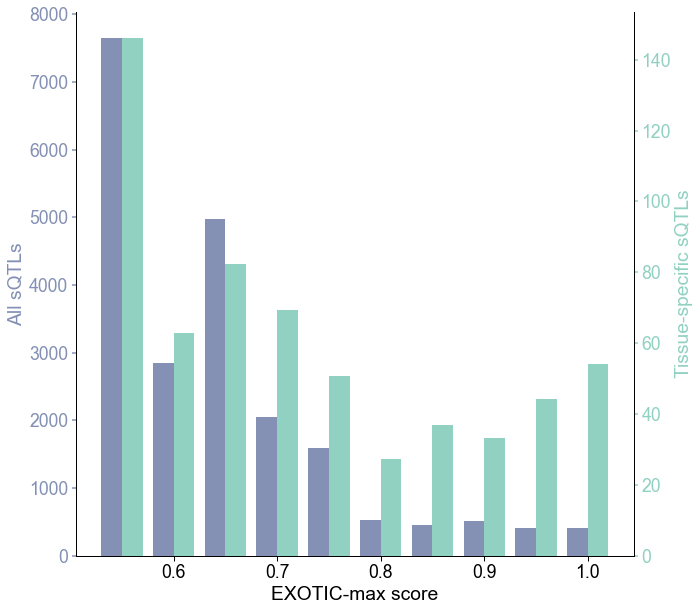

In [257]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'




sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(figsize=(10,10))
data = concat_final.reset_index()
# ax.bar(x=[1,2,3], y=[2,3,4], )
ax1_ = ax.bar(data.EXOTIC_bin_start.values, data.Ratio_Exon_sQTL_total.values,
#        yerr=error,
       align='edge',
       
       color='#8491B4FF',
       width=-0.020
#        ecolor='black',
#        color=list(reversed(sns.color_palette('mako'))),
#        color=sns.color_palette('YlOrBr'),
#        zorder=3,
#        **hfont
      )
ax2 = ax.twinx()
ax2_ = ax2.bar(data.EXOTIC_bin_start.values, data.Ratio_Exon_sQTL.values, color='#91D1C2FF', align='edge', width=0.02)
# ax2.set_xlim(1.5,20.5)
# ax.set_xticks(np.arange(2,21))

# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x, 0)))
# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.label.set_color('#8491B4FF')
ax2.yaxis.label.set_color('#91D1C2FF')

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors='#8491B4FF', **tkw)
ax2.tick_params(axis='y', colors='#91D1C2FF', **tkw)
ax.set_ylabel('All sQTLs')
ax.set_xlabel('EXOTIC-max score')
# plt.xticks([0.5,0.6, 0.7, 0.8, 0.9 ,1])
# ax.set_xticks(list(ax.get_xticks()))
ax2.set_ylabel('Tissue-specific sQTLs')
ax.spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)

# ax.set_ylim(0,4500)
# ax2.set_ylim(0,1)
# ax.text(-0.1, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')


In [87]:
concat_final = pd.read_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_tissues_Rdata_final_min.parquet')
concat_final = concat_final.reset_index()

bins = np.arange(0, 0.5, 0.05)
labels = bins.copy()
labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]


concat_final["EXOTIC_bin_start"] = concat_final["EXOTIC_bin_start"].astype(float)

concat_final["EXOTIC_bins"] = pd.cut(concat_final["EXOTIC_bin_start"], bins=bins, labels=labels_ratio, include_lowest=True)
concat_final = concat_final[['EXOTIC_bins', 'snpId', 'snpId_total']].groupby('EXOTIC_bins').sum().reset_index()
concat_final["EXOTIC_bin_start"] = concat_final["EXOTIC_bins"].apply(lambda r: r.split(' - ')[0])

concat_final

,EXOTIC_bins,snpId,snpId_total,EXOTIC_bin_start
0,0.0 - 0.05,44113.0,958713.0,0.0
1,0.05 - 0.1,34026.0,1413981.0,0.05
2,0.1 - 0.15,22387.0,1053840.0,0.1
3,0.15 - 0.2,11773.0,859753.0,0.15
4,0.2 - 0.25,3651.0,409378.0,0.2
5,0.25 - 0.3,13086.0,1153301.0,0.25
6,0.3 - 0.35,9040.0,774092.0,0.3
7,0.35 - 0.4,20968.0,1103236.0,0.35
8,0.4 - 0.45,6608.0,386830.0,0.4


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


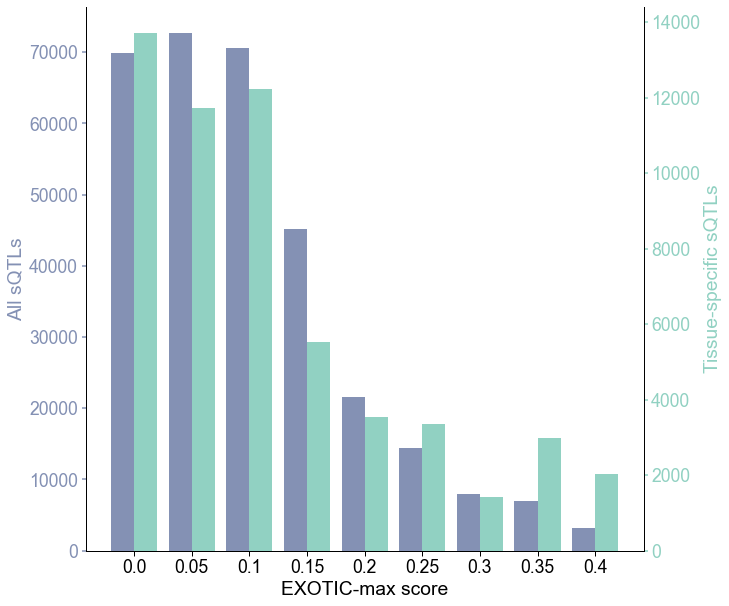

In [123]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'




sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(figsize=(10,10))
data = concat_final.reset_index()
# ax.bar(x=[1,2,3], y=[2,3,4], )
ax1_ = ax.bar(data.EXOTIC_bin_start.values, data.snpId_total.values,
#        yerr=error,
       align='edge',
       
       color='#8491B4FF',
       width=-0.40
#        ecolor='black',
#        color=list(reversed(sns.color_palette('mako'))),
#        color=sns.color_palette('YlOrBr'),
#        zorder=3,
#        **hfont
      )
ax2 = ax.twinx()
ax2_ = ax2.bar(data.EXOTIC_bin_start.values, data.snpId.values, color='#91D1C2FF', align='edge', width=0.4)
# ax2.set_xlim(1.5,20.5)
# ax.set_xticks(np.arange(2,21))

# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x, 0)))
# ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.label.set_color('#8491B4FF')
ax2.yaxis.label.set_color('#91D1C2FF')

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors='#8491B4FF', **tkw)
ax2.tick_params(axis='y', colors='#91D1C2FF', **tkw)
ax.set_ylabel('All sQTLs')
ax.set_xlabel('EXOTIC-max score')
# plt.xticks([0.5,0.6, 0.7, 0.8, 0.9 ,1])
# ax.set_xticks(list(ax.get_xticks()))
ax2.set_ylabel('Tissue-specific sQTLs')
ax.spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)

# ax.set_ylim(0,4500)
# ax2.set_ylim(0,1)
# ax.text(-0.1, 1.05, 'a', transform=ax.transAxes, size=24, weight='bold')


In [152]:
merge_exotic_sqtl.shape

(185991, 43)

In [151]:
merge_exotic_sqtl.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata.parquet')

In [190]:
tmp.to_parquet('/gstock/EXOTIC/data/QTL/sQTL_density_Rdata2.parquet')

In [126]:
merge_exotic_sqtl.loc[merge_exotic_sqtl['Tissue'].str.contains('Skin') & (merge_exotic_sqtl['EXOTIC_max'] > 0.9)]

,symbol,ensg,MAP,Exon,mean_proportion,EXOTIC_max,EXOTIC_max_tissues_corrected,Gene,Gene_type,Gene stable ID,...,info,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perms,pv.emp
2417,ADAM15,ENSG00000143537,ADAM15_155034380-155034451,155034380-155034451,0.071550,0.958610,Skin - Sun Exposed (Lower leg),ADAM15,Multi Isoform,ENSG00000143537,...,"0,354,230,21",1.000000e-14,0.287598,10100,0.745471,0.927460,Skin - Sun Exposed (Lower leg),ENSG00000143537,NaN,NaN
2418,ADAM15,ENSG00000143537,ADAM15_155034380-155034451,155034380-155034451,0.071550,0.958610,Skin - Sun Exposed (Lower leg),ADAM15,Multi Isoform,ENSG00000143537,...,"0,248,270,87",3.580247e-12,0.041698,10100,0.959113,0.989503,Skin - Sun Exposed (Lower leg),ENSG00000143537,NaN,NaN
2419,ADAM15,ENSG00000143537,ADAM15_155034380-155034451,155034380-155034451,0.071550,0.958610,Skin - Sun Exposed (Lower leg),ADAM15,Multi Isoform,ENSG00000143537,...,"0,372,215,18",1.000000e-14,0.305174,10100,0.734185,0.923522,Skin - Sun Exposed (Lower leg),ENSG00000143537,NaN,NaN
2420,ADAM15,ENSG00000143537,ADAM15_155034380-155034451,155034380-155034451,0.071550,0.958610,Skin - Sun Exposed (Lower leg),ADAM15,Multi Isoform,ENSG00000143537,...,"0,141,315,149",7.481117e-08,2.735341,10100,0.063261,0.426769,Skin - Sun Exposed (Lower leg),ENSG00000143537,NaN,NaN
2421,ADAM15,ENSG00000143537,ADAM15_155034380-155034451,155034380-155034451,0.071550,0.958610,Skin - Sun Exposed (Lower leg),ADAM15,Multi Isoform,ENSG00000143537,...,"0,143,313,149",4.257667e-08,2.788212,10100,0.059796,0.417934,Skin - Sun Exposed (Lower leg),ENSG00000143537,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124722,SLC37A2,ENSG00000134955,SLC37A2_124956100-124956127,124956100-124956127,0.100640,0.953804,Skin - Not Sun Exposed (Suprapubic),SLC37A2,Multi Isoform,ENSG00000134955,...,"0,394,112,11",6.349217e-06,3.784043,10100,0.023859,0.303328,Skin - Not Sun Exposed (Suprapubic),ENSG00000134955,NaN,NaN
134932,STIM2,ENSG00000109689,STIM2_27009605-27009628,27009605-27009628,0.212430,0.935891,Skin - Sun Exposed (Lower leg),STIM2,Multi Isoform,ENSG00000109689,...,"0,296,244,65",1.809645e-04,2.545790,10100,0.076230,0.458083,Skin - Sun Exposed (Lower leg),ENSG00000109689,NaN,NaN
134933,STIM2,ENSG00000109689,STIM2_27024141-27024618,27024141-27024618,0.380850,0.935027,Skin - Sun Exposed (Lower leg),STIM2,Multi Isoform,ENSG00000109689,...,"0,296,244,65",1.809645e-04,2.545790,10100,0.076230,0.458083,Skin - Sun Exposed (Lower leg),ENSG00000109689,NaN,NaN
174303,WDR44,ENSG00000131725,WDR44_117575331-117575522,117575331-117575522,0.976550,0.900414,Skin - Not Sun Exposed (Suprapubic),WDR44,Multi Isoform,ENSG00000131725,...,"0,474,14,29",2.183898e-04,0.196860,10100,0.821404,0.954223,Skin - Not Sun Exposed (Suprapubic),ENSG00000131725,NaN,NaN


In [139]:
cutoff_sqtl = merge_exotic_sqtl[['EXOTIC_max', 'Tissue']].groupby('Tissue').max()
cutoff_sqtl.to_excel('/gstock/EXOTIC/data/QTL/sQTL_cutoff_Rdata.xlsx')

In [18]:
list(exotic.columns)

['symbol',
 'ensg',
 'HGNC',
 'Exon',
 'Ratio_num',
 'mRNA_nb',
 'mRNA_nb_total',
 'MAP',
 'mean_proportion',
 'Adipose - Subcutaneous_exotic',
 'Adipose - Visceral (Omentum)_exotic',
 'Adrenal Gland_exotic',
 'Artery - Aorta_exotic',
 'Artery - Coronary_exotic',
 'Artery - Tibial_exotic',
 'Bladder_exotic',
 'Brain - Amygdala_exotic',
 'Brain - Anterior cingulate cortex (BA24)_exotic',
 'Brain - Caudate (basal ganglia)_exotic',
 'Brain - Cerebellar Hemisphere_exotic',
 'Brain - Cerebellum_exotic',
 'Brain - Cortex_exotic',
 'Brain - Frontal Cortex (BA9)_exotic',
 'Brain - Hippocampus_exotic',
 'Brain - Hypothalamus_exotic',
 'Brain - Nucleus accumbens (basal ganglia)_exotic',
 'Brain - Putamen (basal ganglia)_exotic',
 'Brain - Spinal cord (cervical c-1)_exotic',
 'Brain - Substantia nigra_exotic',
 'Breast - Mammary Tissue_exotic',
 'Cells - Cultured fibroblasts_exotic',
 'Cells - EBV-transformed lymphocytes_exotic',
 'Cervix - Ectocervix_exotic',
 'Cervix - Endocervix_exotic',
 'Col

# EXOTIC file combined with BIOMART for ENS IDs

In [6]:
exotic_biomart = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_corrected_biomart_for_QTL_corrected.parquet')
exotic_biomart['OK_join'] = exotic_biomart['OK'].apply(lambda r : ','.join(r))
exotic_biomart.symbol.nunique()

3854

In [43]:
exotic_biomart[['symbol', 'Gene_ID', 'HGNC_ID', 'Exon', 'Ratio_num', 'mRNA_nb', 'OK_bronze',
       'OK_silver', 'OK_gold', 'OK', 'Exon_start_GRCh37',
       'Exon_end_GRCh37', 'CHROM', 'Gene_start_GRCh38',
       'Gene_end_GRCh38',  'Gene_start_GRCh37',
       'Gene_end_GRCh37']].to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_above_thresholds.xlsx', index=False)

### Mapping of all sQTLs over EXOTIC genes with the same tissue

In [ ]:
sqtlseeker_dir = '/gstock/biolo_datasets/QTL/sqlseeker-2/sQTLs.GTEx.V8.RSEM/'
sqtlseeker_listdir = sorted([d for d in os.listdir(sqtlseeker_dir) if 'parquet' not in d])

def mp_sqtl(tissue, l_df):
    sqtlseeker_tmp = pd.read_csv(sqtlseeker_dir + tissue + '/sqtls-0.05fdr.permuted.tsv.gz', compression='gzip', sep='\t')
    sqtlseeker_tmp['Tissue'] = tissue
    sqtlseeker_tmp['gene_id'] = sqtlseeker_tmp['geneId'].apply(lambda r: r.split('.')[0])
#     merge = pd.merge(merge_biomart, sqtlseeker_tmp, right_on='gene_id', left_on='Gene stable ID')
    l_df.append(sqtlseeker_tmp)


m = multiprocessing.Manager()
l_df = m.list()
# for tissue in sqtlseeker_listdir:
parmap.starmap(mp_sqtl, list(zip(sqtlseeker_listdir)), l_df, pm_pbar=True)

concat_df_sqtlseeker_dir_complete = pd.concat(list(l_df)).sort_values(by=['gene_id'])
concat_df_sqtlseeker_dir_complete

In [4]:
concat_df_sqtlseeker_dir_complete.snpId.nunique()

344211

In [57]:
sqtlseeker_dir = '/gstock/biolo_datasets/QTL/sqlseeker-2/sQTLs.GTEx.V8.RSEM/'
sqtlseeker_listdir = sorted([d for d in os.listdir(sqtlseeker_dir) if 'parquet' not in d])

def mp_sqtl(tissue, l_df):
    sqtlseeker_tmp = pd.read_csv(sqtlseeker_dir + tissue + '/sqtls-0.05fdr.permuted.tsv.gz', compression='gzip', sep='\t')
    sqtlseeker_tmp['Tissue'] = tissue
    sqtlseeker_tmp['gene_id'] = sqtlseeker_tmp['geneId'].apply(lambda r: r.split('.')[0])
    merge = pd.merge(merge_biomart, sqtlseeker_tmp, right_on='gene_id', left_on='Gene stable ID')
    l_df.append(merge)


m = multiprocessing.Manager()
l_df = m.list()
# for tissue in sqtlseeker_listdir:
parmap.starmap(mp_sqtl, list(zip(sqtlseeker_listdir)), l_df, pm_pbar=True)

concat_df_sqtlseeker_dir_all_genes_corrected = pd.concat(list(l_df)).sort_values(by=['gene_id'])
concat_df_sqtlseeker_dir_all_genes_corrected = concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['Gene_type'] == 'Multi Isoform']
concat_df_sqtlseeker_dir_all_genes_corrected

100%|██████████| 49/49 [00:08<00:00,  5.56it/s]


,Gene,Gene_type,Gene stable ID,Gene name,Gene end (bp),Gene start (bp),Gene type,geneId,variants.cis,LD,...,info,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perm,pv.emp.perm
22062,DPM1,Multi Isoform,ENSG00000000419,DPM1,50958555,50934867,protein_coding,ENSG00000000419.12,23,0.011631,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,1000.0,0.007992
22061,DPM1,Multi Isoform,ENSG00000000419,DPM1,50958555,50934867,protein_coding,ENSG00000000419.12,23,0.011631,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,1000.0,0.007992
22060,DPM1,Multi Isoform,ENSG00000000419,DPM1,50958555,50934867,protein_coding,ENSG00000000419.12,23,0.011631,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,1000.0,0.007992
22063,DPM1,Multi Isoform,ENSG00000000419,DPM1,50958555,50934867,protein_coding,ENSG00000000419.12,23,0.011631,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,1000.0,0.007992
9064,DPM1,Multi Isoform,ENSG00000000419,DPM1,50958555,50934867,protein_coding,ENSG00000000419.12,17,0.024091,...,"0,219,14,0",0.000004,0.824819,3629,0.369421,0.799127,Adrenal Gland,ENSG00000000419,1000.0,0.000999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,ADORA3,Multi Isoform,ENSG00000282608,ADORA3,111503633,111499429,protein_coding,ENSG00000282608.1,33,0.072180,...,"0,20,182,329",0.000102,0.406211,10100,0.660628,0.902969,Nerve - Tibial,ENSG00000282608,1000.0,0.001998
1935,ADORA3,Multi Isoform,ENSG00000282608,ADORA3,111503633,111499429,protein_coding,ENSG00000282608.1,33,0.072180,...,"0,20,187,324",0.000057,0.317546,10100,0.728839,0.926138,Nerve - Tibial,ENSG00000282608,1000.0,0.001998
1129,ADORA3,Multi Isoform,ENSG00000282608,ADORA3,111503633,111499429,protein_coding,ENSG00000282608.1,29,0.253320,...,"0,26,149,165",0.000310,0.383695,10100,0.677854,0.913063,Artery - Aorta,ENSG00000282608,1000.0,0.012987
1943,ADORA3,Multi Isoform,ENSG00000282608,ADORA3,111503633,111499429,protein_coding,ENSG00000282608.1,33,0.072180,...,"0,21,183,327",0.000131,0.410236,10100,0.658153,0.902100,Nerve - Tibial,ENSG00000282608,1000.0,0.001998


In [11]:
concat_df_sqtlseeker_dir_all_genes_corrected['Gene name'].nunique()

7858

In [6]:
sqtlseeker_dir = '/gstock/biolo_datasets/QTL/sqlseeker-2/sQTLs.GTEx.V8.RSEM/'
sqtlseeker_listdir = sorted([d for d in os.listdir(sqtlseeker_dir) if 'parquet' not in d])

def mp_sqtl(tissue, l_df):
    sqtlseeker_tmp = pd.read_csv(sqtlseeker_dir + tissue + '/sqtls-0.05fdr.permuted.tsv.gz', compression='gzip', sep='\t')
    sqtlseeker_tmp['Tissue'] = tissue
    sqtlseeker_tmp['gene_id'] = sqtlseeker_tmp['geneId'].apply(lambda r: r.split('.')[0])
    merge = pd.merge(exotic_biomart, sqtlseeker_tmp, right_on='gene_id', left_on='Gene_ID')
    l_df.append(merge)


m = multiprocessing.Manager()
l_df = m.list()
# for tissue in sqtlseeker_listdir:
parmap.starmap(mp_sqtl, list(zip(sqtlseeker_listdir)), l_df, pm_pbar=True)

concat_df_sqtlseeker_dir_total = pd.concat(list(l_df)).sort_values(by=['gene_id', 'MAP']).drop_duplicates(subset=['gene_id', 'MAP', 'Tissue', 'snpId'])
concat_df_sqtlseeker_dir_total

100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,info,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perms,pv.emp
31518,DPM1_49557666-49557746,0.25,1,DPM1,0.347887,0.467659,0.379601,0.399377,0.474517,0.259736,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,NaN,NaN
31519,DPM1_49557666-49557746,0.25,1,DPM1,0.347887,0.467659,0.379601,0.399377,0.474517,0.259736,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,NaN,NaN
31520,DPM1_49557666-49557746,0.25,1,DPM1,0.347887,0.467659,0.379601,0.399377,0.474517,0.259736,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,NaN,NaN
31521,DPM1_49557666-49557746,0.25,1,DPM1,0.347887,0.467659,0.379601,0.399377,0.474517,0.259736,...,"0,555,19,0",0.000312,0.019999,5016,0.888380,0.971134,Thyroid,ENSG00000000419,NaN,NaN
10741,DPM1_49557666-49557746,0.25,1,DPM1,0.347887,0.467659,0.379601,0.399377,0.474517,0.259736,...,"0,219,14,0",0.000004,0.824819,3629,0.369421,0.799127,Adrenal Gland,ENSG00000000419,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50808,MATR3_138650364-138650425,0.75,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",0.000079,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999
50809,MATR3_138650364-138650425,0.75,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",0.000079,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999
50810,MATR3_138650364-138650425,0.75,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",0.000079,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999
50811,MATR3_138650364-138650425,0.75,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",0.000079,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999


In [7]:
sqtlseeker_dir = '/gstock/biolo_datasets/QTL/sqlseeker-2/sQTLs.GTEx.V8.RSEM/'
sqtlseeker_listdir = sorted([d for d in os.listdir(sqtlseeker_dir) if 'parquet' not in d])

def mp_sqtl(tissue, l_df):
    sqtlseeker_tmp = pd.read_csv(sqtlseeker_dir + tissue + '/sqtls-0.05fdr.permuted.tsv.gz', compression='gzip', sep='\t')
    sqtlseeker_tmp['Tissue'] = tissue
    sqtlseeker_tmp['gene_id'] = sqtlseeker_tmp['geneId'].apply(lambda r: r.split('.')[0])
    merge = pd.merge(exotic_biomart.loc[exotic_biomart['OK_join'].str.contains(tissue)], sqtlseeker_tmp, right_on='gene_id', left_on='Gene_ID')
    l_df.append(merge)


m = multiprocessing.Manager()
l_df = m.list()

parmap.starmap(mp_sqtl, list(zip(sqtlseeker_listdir)), l_df, pm_pbar=True)

concat_df_sqtlseeker_dir = pd.concat(l_df).sort_values(by=['gene_id', 'MAP']).drop_duplicates(subset=['gene_id', 'MAP', 'Tissue', 'snpId'])
concat_df_sqtlseeker_dir

  0%|          | 0/49 [00:00<?, ?it/s]/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarn

,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,info,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perms,pv.emp
4022,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,"0,31,134,157",6.091186e-07,2.786734,10100,0.064251,0.449160,Testis,ENSG00000000460,NaN,NaN
4023,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,"0,52,159,111",2.653543e-06,2.582973,10100,0.077814,0.479461,Testis,ENSG00000000460,NaN,NaN
4024,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,"0,52,159,111",2.653543e-06,2.582973,10100,0.077814,0.479461,Testis,ENSG00000000460,NaN,NaN
4025,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,"0,52,159,111",2.653543e-06,2.582973,10100,0.077814,0.479461,Testis,ENSG00000000460,NaN,NaN
4026,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,"0,52,159,111",2.653543e-06,2.582973,10100,0.077814,0.479461,Testis,ENSG00000000460,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12323,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",7.886939e-05,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999
12324,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",7.886939e-05,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999
12325,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",7.886939e-05,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999
12326,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,"0,78,187,218",7.886939e-05,3.526732,10100,0.029205,0.323860,Cells - Cultured fibroblasts,ENSG00000280987,1000.0,0.000999


In [109]:
concat_df_sqtlseeker_dir.gene_id.nunique()

855

In [17]:
concat_df_sqtlseeker_dir_all_genes_corrected

,Gene,Gene_type,Gene stable ID,Gene name,Gene end (bp),Gene start (bp),Gene type,geneId,variants.cis,LD,...,info,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perm,pv.emp.perm
51651,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,185,43,102",0.000543,3.607540,10100,0.028908,0.377674,Esophagus - Gastroesophageal Junction,ENSG00000000003,1000.0,0.002997
51654,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,184,44,102",0.000887,2.130104,10100,0.121968,0.596560,Esophagus - Gastroesophageal Junction,ENSG00000000003,1000.0,0.002997
51653,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,196,42,92",0.000672,3.121201,10100,0.046431,0.447327,Esophagus - Gastroesophageal Junction,ENSG00000000003,1000.0,0.002997
51652,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,184,43,103",0.000615,2.195003,10100,0.113058,0.584302,Esophagus - Gastroesophageal Junction,ENSG00000000003,1000.0,0.002997
51650,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,196,43,91",0.000434,2.968800,10100,0.053856,0.469799,Esophagus - Gastroesophageal Junction,ENSG00000000003,1000.0,0.002997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,ADORA3,Multi Isoform,ENSG00000282608,ADORA3,111503633,111499429,protein_coding,ENSG00000282608.1,33,0.072180,...,"0,41,215,275",0.000485,0.593332,10100,0.550441,0.861797,Nerve - Tibial,ENSG00000282608,1000.0,0.001998
5532,C2orf81,Single Isoform,ENSG00000284308,C2orf81,74421591,74414176,protein_coding,ENSG00000284308.1,9,0.019051,...,"0,268,98,15",0.001028,1.433703,4178,0.248624,0.710257,Artery - Aorta,ENSG00000284308,1000.0,0.002997
5531,C2orf81,Single Isoform,ENSG00000284308,C2orf81,74421591,74414176,protein_coding,ENSG00000284308.1,9,0.019051,...,"0,268,98,15",0.000637,1.432883,4178,0.248624,0.710257,Artery - Aorta,ENSG00000284308,1000.0,0.002997
5530,C2orf81,Single Isoform,ENSG00000284308,C2orf81,74421591,74414176,protein_coding,ENSG00000284308.1,9,0.019051,...,"0,270,96,15",0.000383,1.402612,4178,0.256999,0.717561,Artery - Aorta,ENSG00000284308,1000.0,0.002997


In [21]:
cols = ['gene_id', 'snpId']
concat_excel_stats_all_genes_corrected = concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['gene_id'].isin(concat_df_sqtlseeker_dir_all_genes_corrected.gene_id.unique())]
concat_excel_stats_all_genes_corrected = pd.concat([concat_excel_stats_all_genes_corrected[['Tissue', col]].drop_duplicates()['Tissue'].value_counts() for col in cols], axis=1).sort_index()
concat_excel_stats_all_genes_corrected.columns = ['All EXsGenes', 'All sQTL']
# concat_excel_stats = pd.merge(concat_excel_stats, gtex_colors['Color'], left_index=True, right_index=True)
# concat_excel_stats['color'] = u"\u2B1B"
concat_excel_stats_all_genes_corrected = concat_excel_stats_all_genes_corrected[['All EXsGenes', 'All sQTL']]
concat_excel_stats_all_genes_corrected.loc['Total'] = [concat_df_sqtlseeker_dir_all_genes_corrected[col].nunique() for col in cols]
concat_excel_stats_all_genes_corrected.loc['Average'] = concat_excel_stats_all_genes_corrected.mean()
concat_excel_stats_all_genes_corrected = concat_excel_stats_all_genes_corrected.round(0).astype(int)
concat_excel_stats_all_genes_corrected


,All EXsGenes,All sQTL
Adipose - Subcutaneous,2783,94781
Adipose - Visceral (Omentum),2317,73086
Adrenal Gland,1437,39720
Artery - Aorta,2117,66404
Artery - Coronary,1283,34032
Artery - Tibial,2558,85703
Brain - Amygdala,519,12487
Brain - Anterior cingulate cortex (BA24),679,15754
Brain - Caudate (basal ganglia),958,25887
Brain - Cerebellar Hemisphere,1122,30435


In [28]:
cols = ['gene_id', 'MAP', 'snpId']
# concat_df_sqtlseeker_dir_total_filtered = concat_df_sqtlseeker_dir_total.loc[concat_df_sqtlseeker_dir_total['gene_id'].isin(concat_df_sqtlseeker_dir.gene_id.unique())]
concat_excel_stats_total = pd.concat([concat_df_sqtlseeker_dir_total[['Tissue', col]].drop_duplicates()['Tissue'].value_counts() for col in cols], axis=1).sort_index()
concat_excel_stats_total.columns = ['Total EXsGenes', 'Total EXExons', 'Total sQTL']
# concat_excel_stats = pd.merge(concat_excel_stats, gtex_colors['Color'], left_index=True, right_index=True)
# concat_excel_stats['color'] = u"\u2B1B"
concat_excel_stats_total = concat_excel_stats_total[['Total EXsGenes', 'Total EXExons', 'Total sQTL']]
concat_excel_stats_total.loc['Total'] = [concat_df_sqtlseeker_dir_total[col].nunique() for col in cols]
concat_excel_stats_total.loc['Average'] = concat_excel_stats_total.mean()
concat_excel_stats_total = concat_excel_stats_total.round(0).astype(int)
concat_excel_stats_total


,Total EXsGenes,Total EXExons,Total sQTL
Adipose - Subcutaneous,1032,3591,40217
Adipose - Visceral (Omentum),868,2930,30983
Adrenal Gland,541,1751,16056
Artery - Aorta,805,2768,29601
Artery - Coronary,483,1556,13606
Artery - Tibial,986,3409,36599
Brain - Amygdala,196,656,4761
Brain - Anterior cingulate cortex (BA24),259,880,5456
Brain - Caudate (basal ganglia),366,1272,11090
Brain - Cerebellar Hemisphere,434,1569,12599


In [186]:
cols = ['gene_id', 'MAP', 'snpId']
concat_df_sqtlseeker_dir_total_filtered = concat_df_sqtlseeker_dir_total.loc[concat_df_sqtlseeker_dir_total['gene_id'].isin(concat_df_sqtlseeker_dir.gene_id.unique())]
concat_excel_stats_total = pd.concat([concat_df_sqtlseeker_dir_total_filtered[['Tissue', col]].drop_duplicates()['Tissue'].value_counts() for col in cols], axis=1).sort_index()
concat_excel_stats_total.columns = ['Total EXsGenes', 'Total EXExons', 'Total sQTL']
# concat_excel_stats = pd.merge(concat_excel_stats, gtex_colors['Color'], left_index=True, right_index=True)
# concat_excel_stats['color'] = u"\u2B1B"
concat_excel_stats_total = concat_excel_stats_total[['Total EXsGenes', 'Total EXExons', 'Total sQTL']]
concat_excel_stats_total.loc['Total'] = [concat_df_sqtlseeker_dir_total_filtered[col].nunique() for col in cols]
concat_excel_stats_total.loc['Average'] = concat_excel_stats_total.mean()
concat_excel_stats_total = concat_excel_stats_total.round(0).astype(int)
concat_excel_stats_total


,Total EXsGenes,Total EXExons,Total sQTL
Adipose - Subcutaneous,557,2115,26258
Adipose - Visceral (Omentum),496,1879,21377
Adrenal Gland,362,1295,11621
Artery - Aorta,461,1784,20585
Artery - Coronary,319,1190,10493
Artery - Tibial,534,2010,24167
Brain - Amygdala,133,488,3848
Brain - Anterior cingulate cortex (BA24),179,663,3967
Brain - Caudate (basal ganglia),250,900,8514
Brain - Cerebellar Hemisphere,292,1098,9449


In [178]:
cols = ['gene_id', 'MAP', 'snpId']
concat_excel_stats = pd.concat([concat_df_sqtlseeker_dir[['Tissue', col]].drop_duplicates()['Tissue'].value_counts() for col in cols], axis=1).sort_index()
concat_excel_stats.columns = ['EXsGenes', 'EXExons', 'sQTL']
# concat_excel_stats = pd.merge(concat_excel_stats, gtex_colors['Color'], left_index=True, right_index=True)
# concat_excel_stats['color'] = u"\u2B1B"
concat_excel_stats = concat_excel_stats[['EXsGenes', 'EXExons', 'sQTL']]
concat_excel_stats.loc['Total'] = [concat_df_sqtlseeker_dir[col].nunique() for col in cols]
concat_excel_stats.loc['Average'] = concat_excel_stats.mean()
concat_excel_stats = concat_excel_stats.round(0).astype(int)
concat_excel_stats


,EXsGenes,EXExons,sQTL
Adipose - Subcutaneous,2,2,52
Adrenal Gland,12,33,660
Artery - Aorta,5,8,99
Artery - Coronary,2,5,41
Artery - Tibial,38,75,1497
Brain - Amygdala,2,12,43
Brain - Cerebellar Hemisphere,48,94,1311
Brain - Cerebellum,55,80,1231
Brain - Cortex,5,6,104
Brain - Hippocampus,4,20,54


In [190]:
concat_df = pd.concat([concat_excel_stats_total, concat_excel_stats], axis=1).fillna(0).astype(int)
concat_df['Ratio sQTL'] = concat_df['sQTL'] / concat_df['Total sQTL'] 
concat_df['Ratio sQTL/sGenes Total'] = concat_df['Total sQTL'] / concat_df['Total EXsGenes'] 
concat_df['Ratio sQTL/sGenes EXOTIC'] = concat_df['sQTL'] / concat_df['EXsGenes'] 
concat_df = concat_df.fillna(0)
concat_df

,Total EXsGenes,Total EXExons,Total sQTL,EXsGenes,EXExons,sQTL,Ratio sQTL,Ratio sQTL/sGenes Total,Ratio sQTL/sGenes EXOTIC
Adipose - Subcutaneous,557,2115,26258,2,2,52,0.001980,47.141831,26.000000
Adipose - Visceral (Omentum),496,1879,21377,0,0,0,0.000000,43.098790,0.000000
Adrenal Gland,362,1295,11621,12,33,660,0.056794,32.102210,55.000000
Artery - Aorta,461,1784,20585,5,8,99,0.004809,44.652928,19.800000
Artery - Coronary,319,1190,10493,2,5,41,0.003907,32.893417,20.500000
Artery - Tibial,534,2010,24167,38,75,1497,0.061944,45.256554,39.394737
Brain - Amygdala,133,488,3848,2,12,43,0.011175,28.932331,21.500000
Brain - Anterior cingulate cortex (BA24),179,663,3967,0,0,0,0.000000,22.162011,0.000000
Brain - Caudate (basal ganglia),250,900,8514,0,0,0,0.000000,34.056000,0.000000
Brain - Cerebellar Hemisphere,292,1098,9449,48,94,1311,0.138745,32.359589,27.312500


In [106]:
concat_df_sqtlseeker_dir[['Tissue', 'MAP']].drop_duplicates()['Tissue'].value_counts()

Muscle - Skeletal                        812
Cells - Cultured fibroblasts             737
Testis                                   423
Whole Blood                              190
Cells - EBV-transformed lymphocytes      132
Heart - Left Ventricle                   106
Brain - Cerebellar Hemisphere             94
Brain - Cerebellum                        80
Artery - Tibial                           75
Heart - Atrial Appendage                  55
Pancreas                                  52
Esophagus - Mucosa                        46
Liver                                     38
Adrenal Gland                             33
Pituitary                                 23
Colon - Transverse                        23
Brain - Hippocampus                       20
Spleen                                    19
Thyroid                                   14
Lung                                      13
Brain - Amygdala                          12
Small Intestine - Terminal Ileum           9
Esophagus 

In [105]:
concat_df_sqtlseeker_dir[['Tissue', 'snpId']].drop_duplicates()['Tissue'].value_counts()

Muscle - Skeletal                        12139
Cells - Cultured fibroblasts              8772
Testis                                    7362
Whole Blood                               2345
Artery - Tibial                           1497
Heart - Atrial Appendage                  1447
Heart - Left Ventricle                    1433
Cells - EBV-transformed lymphocytes       1390
Esophagus - Mucosa                        1383
Brain - Cerebellar Hemisphere             1311
Brain - Cerebellum                        1231
Spleen                                     835
Adrenal Gland                              660
Pancreas                                   455
Liver                                      371
Esophagus - Muscularis                     367
Pituitary                                  278
Nerve - Tibial                             207
Thyroid                                    188
Colon - Transverse                         127
Stomach                                    125
Brain - Corte

In [12]:
list(concat_df_sqtlseeker_dir.columns)

['MAP',
 'Ratio_num',
 'mRNA_nb',
 'symbol',
 'Adipose - Subcutaneous_exotic',
 'Adipose - Visceral (Omentum)_exotic',
 'Adrenal Gland_exotic',
 'Artery - Aorta_exotic',
 'Artery - Coronary_exotic',
 'Artery - Tibial_exotic',
 'Bladder_exotic',
 'Brain - Amygdala_exotic',
 'Brain - Anterior cingulate cortex (BA24)_exotic',
 'Brain - Caudate (basal ganglia)_exotic',
 'Brain - Cerebellar Hemisphere_exotic',
 'Brain - Cerebellum_exotic',
 'Brain - Cortex_exotic',
 'Brain - Frontal Cortex (BA9)_exotic',
 'Brain - Hippocampus_exotic',
 'Brain - Hypothalamus_exotic',
 'Brain - Nucleus accumbens (basal ganglia)_exotic',
 'Brain - Putamen (basal ganglia)_exotic',
 'Brain - Spinal cord (cervical c-1)_exotic',
 'Brain - Substantia nigra_exotic',
 'Breast - Mammary Tissue_exotic',
 'Cells - Cultured fibroblasts_exotic',
 'Cells - EBV-transformed lymphocytes_exotic',
 'Cervix - Ectocervix_exotic',
 'Cervix - Endocervix_exotic',
 'Colon - Sigmoid_exotic',
 'Colon - Transverse_exotic',
 'Esophagus -

In [9]:
concat_df_sqtlseeker_dir[['snpId', 'Tissue']].drop_duplicates()

,snpId,Tissue
4022,1_169833737_C_T_b38,Testis
4023,1_169798892_T_C_b38,Testis
4024,1_169798939_C_A_b38,Testis
4025,1_169816204_CT_C_b38,Testis
4026,1_169818306_A_G_b38,Testis
...,...,...
13951,5_139283780_G_C_b38,Muscle - Skeletal
13958,5_139286997_G_T_b38,Muscle - Skeletal
13964,5_139278588_A_G_b38,Muscle - Skeletal
13965,5_139283108_T_G_b38,Muscle - Skeletal


#### Number of unique sExGenes

In [246]:
concat_df_sqtlseeker_dir.MAP.nunique()

2545

### Def liftover

In [60]:
from liftover import ChainFile
converter = ChainFile("/gstock/biolo_datasets/variation/benchmark/Databases/CrossMap/GRCh38_to_GRCh37.chain.gz", "GRCh38", "GRCh37")

def apply_liftover(r, name):
    # print(r)
    try:
        output = converter[r["CHROM_GRCh38"]][int(r[name])]
        # print(output)
        converted_pos = output[0][1]
    except KeyError:
        converted_pos = np.nan
    except IndexError:
        converted_pos = np.nan
    return converted_pos

In [49]:
tqdm.pandas()
concat_df_sqtlseeker_dir['snpId'] = concat_df_sqtlseeker_dir['snpId'].str.replace('_b38', '')
concat_df_sqtlseeker_dir[['CHROM_GRCh38', 'POS_GRCh38', 'REF', 'ALT']] = concat_df_sqtlseeker_dir['snpId'].str.split('_', expand=True)
concat_df_sqtlseeker_dir['-logpv'] = concat_df_sqtlseeker_dir['pv'].apply(lambda r: -np.log10(r))
# concat_df_sqtlseeker_dir['POS_GRCh37'] = concat_df_sqtlseeker_dir[['CHROM_GRCh38', 'POS_GRCh38']].progress_apply(lambda r: apply_liftover(r, 'POS_GRCh38'), axis=1)
concat_df_sqtlseeker_dir

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,fdr.svQTL,Tissue,gene_id,nb.perms,pv.emp,CHROM_GRCh38,POS_GRCh38,REF,ALT,-logpv
4022,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,0.449160,Testis,ENSG00000000460,NaN,NaN,1,169833737,C,T,6.215298
4023,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,0.479461,Testis,ENSG00000000460,NaN,NaN,1,169798892,T,C,5.576174
4024,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,0.479461,Testis,ENSG00000000460,NaN,NaN,1,169798939,C,A,5.576174
4025,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,0.479461,Testis,ENSG00000000460,NaN,NaN,1,169816204,CT,C,5.576174
4026,C1orf112_169770047-169770112,0.166667,1,C1orf112,0.618567,0.444660,0.728686,0.346471,0.517964,0.561366,...,0.479461,Testis,ENSG00000000460,NaN,NaN,1,169818306,A,G,5.576174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,0.527550,Muscle - Skeletal,ENSG00000280987,NaN,NaN,5,139283108,T,G,8.097135
13996,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,0.527550,Muscle - Skeletal,ENSG00000280987,NaN,NaN,5,139291660,T,C,8.097135
13997,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,0.978214,Muscle - Skeletal,ENSG00000280987,NaN,NaN,5,139332815,T,C,7.891946
13998,MATR3_138650364-138650425,0.750000,3,MATR3,0.521603,0.517838,0.646324,0.480611,0.496649,0.660195,...,0.573598,Muscle - Skeletal,ENSG00000280987,NaN,NaN,5,139330067,G,A,7.882367


In [ ]:
import seaborn as sns
sns.set_theme(style="white")

kdeplot = sns.JointGrid(data=concat_df_sqtlseeker_dir.loc[concat_df_sqtlseeker_dir['Tissue'] == 'Testis'], x="md", y="-logpv", space=0)
kdeplot.plot_joint(sns.kdeplot,
             fill=True, 
#              clip=((2200, 6800), (10, 25)),
             thresh=0, levels=100, cmap="rocket_r",
            cbar=True)
# kdeplot.ax_marg_x.set_xlim(0,1)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

kdeplot.plot_marginals(sns.histplot, color="#AAAAAA", alpha=1, bins=25)
pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
kdeplot.fig.axes[-1].set_position([.83, 0.25, .15, 0.25])


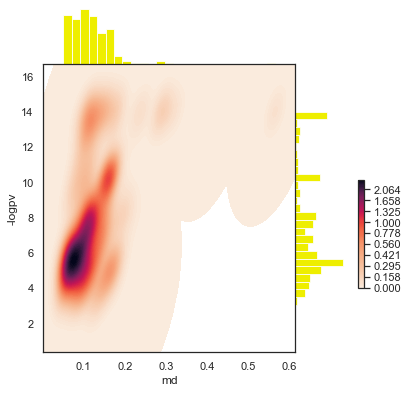

In [91]:

kdeplot = sns.JointGrid(data=concat_df_sqtlseeker_dir.loc[concat_df_sqtlseeker_dir['Tissue'] == 'Brain - Cerebellum'], x="md", y="-logpv", space=0)
kdeplot.plot_joint(sns.kdeplot,
             fill=True, 
#              clip=((2200, 6800), (10, 25)),
             thresh=0, levels=100, cmap="rocket_r",
            cbar=True)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# kdeplot.ax_marg_x.set_xlim(0,1)
kdeplot.plot_marginals(sns.histplot, color="#EEEE00", alpha=1, bins=25)
pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
kdeplot.fig.axes[-1].set_position([.83, 0.25, .15, 0.25])



# GWAS PART

In [3]:
gwas_associations = pd.read_csv('/gstock/biolo_datasets/GWAS/GWAS_catalog_FTP/Latest/gwas-catalog-associations_ontology-annotated.tsv', sep='\t')
gwas_efo = pd.read_csv('/gstock/biolo_datasets/GWAS/GWAS_catalog_FTP/Latest/gwas-efo-trait-mappings.tsv', sep="\t", low_memory=False)
gwas_efo_lite = gwas_efo[["EFO term", "EFO URI", "Parent term", "Parent URI"]].drop_duplicates()
gwas_return = pd.merge(
            gwas_associations,
            gwas_efo_lite,
            left_on="MAPPED_TRAIT_URI",
            right_on="EFO URI",
        )

gwas_return = gwas_return.dropna(subset=["CHR_POS"])
gwas_return = gwas_return.loc[~gwas_return["CHR_POS"].isin(["nan", "NaN", ""])]
# gwas_return = gwas_return.loc[gwas_return['']]
head(gwas_return)

NameError: name 'pd' is not defined

### Merge GWAS on sQTLs

In [14]:
merge_gwas_qtl = pd.merge(gwas_return, concat_df_sqtlseeker_dir, left_on=['CHR_ID', 'CHR_POS'], right_on=['CHROM', 'POS_GRCh38'])
merge_gwas_qtl[['Tissue', 'DISEASE/TRAIT', 'Parent term']].drop_duplicates().sort_values(by='Tissue')

,Tissue,DISEASE/TRAIT,Parent term
746,Adipose - Subcutaneous,Sex hormone-binding globulin levels,Other measurement
732,Adipose - Subcutaneous,Type 2 diabetes,Metabolic disorder
739,Adipose - Subcutaneous,Type 2 diabetes (adjusted for BMI),Metabolic disorder
4993,Adipose - Subcutaneous,Appendicular lean mass,Other measurement
853,Adipose - Subcutaneous,Medication use (drugs used in diabetes),Other measurement
...,...,...,...
3876,Whole Blood,Red cell distribution width,Hematological measurement
952,Whole Blood,Educational attainment (years of education),Other measurement
2536,Whole Blood,Refractive error,Other trait
3622,Whole Blood,Primary biliary cirrhosis,Cancer


In [1]:
# list(merge_gwas_qtl.columns)

In [33]:
print(merge_gwas_qtl.MAP.nunique())
print(merge_gwas_qtl.gene_id.nunique())
print(merge_gwas_qtl.snpId.nunique())

990
325
960


In [46]:
merge_gwas_qtl['P-VALUE'] = merge_gwas_qtl['P-VALUE'].astype(float)
merge_gwas_qtl[['Tissue', 'DISEASE/TRAIT', 'Parent term', 'symbol', 'MAP', 'snpId', 'pv', 'md', 'P-VALUE']].drop_duplicates(subset=["Tissue", "DISEASE/TRAIT", "Parent term", "symbol", "MAP", "snpId", ]).sort_values(by='Tissue').to_excel('/gstock/EXOTIC/data/GWAS/EXOTIC_GWAS_sqtlseeker.xlsx', index=False)

In [31]:
merge_gwas_qtl.to_excel('/gstock/EXOTIC/data/GWAS/EXOTIC_GWAS_sqtlseeker.xlsx', index=False)

In [18]:
merge_gwas_qtl[['CHR_ID', 'CHR_POS']].drop_duplicates()

,CHR_ID,CHR_POS
0,17,46115224
2,15,40424054
4,16,3533173
54,1,16981759
58,1,26448876
...,...,...
5143,19,40344340
5144,19,57643457
5146,16,583764
5148,16,581752


In [2]:
# list(merge_gwas_qtl.columns)

# Export sQTLs on VCF for annotation

In [3]:
import gzip, subprocess
vcfheader = "##fileformat=VCFv4.1\n##fileDate=20090805\n##source=myImputationProgramV3.1\n##reference=file:///seq/references/\n#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\n"
with open('/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_mapping.vcf', 'w') as output_file:
    output_file.write(vcfheader)

concat_df_sqtlseeker_dir['ID'] = '.'
concat_df_sqtlseeker_dir['POS_GRCh38'] = concat_df_sqtlseeker_dir['POS_GRCh38'].astype(int)
concat_df_sqtlseeker_dir[['CHROM', 'POS_GRCh38', 'ID', 'REF', 'ALT', 'ID', 'ID', 'ID']].sort_values(by=['CHROM', 'POS_GRCh38']).drop_duplicates().to_csv('/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_mapping.vcf', mode='a', sep='\t', header=False, index=False)
subprocess.run(['rm', '/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_mapping.vcf.gz'])
subprocess.run(['bgzip', '/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_mapping.vcf'])
subprocess.run(['tabix', '-p', 'vcf', '/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_mapping.vcf.gz'])
subprocess.run(['/biolo/ngs/ensembl-vep-38/vep', '-i', '/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_mapping.vcf.gz', '-o', '/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_mapping_vep.vcf.gz', 
               '--custom', '/data/scratch/gnomAD/v2_liftover/gnomad.genomes.r2.1.1.sites.liftover_grch38.vcf.bgz,gnomAD,vcf,exact,0,AF'])

# concat_df_sqtlseeker_dir[['CHROM', 'POS_GRCh38', 'ID', 'REF', 'ALT', 'ID', 'ID', 'ID']]
# check_df_ok

NameError: name 'concat_df_sqtlseeker_dir' is not defined

### VEP CSQ

In [10]:
vep_csq = pd.read_excel('/gstock/EXOTIC/data/OTHERS/vep_csq.xlsx').set_index('SO_term')
vep_csq

,ID,SO_description,SO_accession,Display_term,IMPACT
SO_term,,,,,
transcript_ablation,1,A feature ablation whereby the deleted region ...,SO:0001893,Transcript ablation,HIGH
splice_acceptor_variant,2,A splice variant that changes the 2 base regio...,SO:0001574,Splice acceptor variant,HIGH
splice_donor_variant,3,A splice variant that changes the 2 base regio...,SO:0001575,Splice donor variant,HIGH
stop_gained,4,A sequence variant whereby at least one base o...,SO:0001587,Stop gained,HIGH
frameshift_variant,5,A sequence variant which causes a disruption o...,SO:0001589,Frameshift variant,HIGH
stop_lost,6,A sequence variant where at least one base of ...,SO:0001578,Stop lost,HIGH
start_lost,7,A codon variant that changes at least one base...,SO:0002012,Start lost,HIGH
transcript_amplification,8,A feature amplification of a region containing...,SO:0001889,Transcript amplification,HIGH
inframe_insertion,9,An inframe non synonymous variant that inserts...,SO:0001821,Inframe insertion,MODERATE


In [67]:
sgenes = sorted(concat_df_sqtlseeker_dir.gene_id.unique().tolist())
sgenes[:10]

['ENSG00000000460',
 'ENSG00000003056',
 'ENSG00000003402',
 'ENSG00000004534',
 'ENSG00000005436',
 'ENSG00000005801',
 'ENSG00000005882',
 'ENSG00000006432',
 'ENSG00000006625',
 'ENSG00000006744']

In [16]:
from cyvcf2 import VCF

def prepare_header(vcf, vep_field, vep_separator):

    index_dict = dict()
    if vep_field:
        for h in vcf.header_iter():
            try:
                if h.info()['ID'] == vep_field:
                    csq_header = h.info()['Description'].split(vep_separator)
                    for elem in csq_header:
                        index_dict[elem] = csq_header.index(elem)
            except:
                pass
    return index_dict



sqtlseeker_exotic = "/gstock/EXOTIC/data/VARIATIONS/sqtlseeker2_exotic_vep.vcf.gz"
vcf = VCF(sqtlseeker_exotic)
index_dict = prepare_header(vcf, "CSQ", '|')
pprint(index_dict)
l = list()
for j, record in tqdm(enumerate(vcf)):
    csq = str(record.INFO.get('CSQ')).split(',')
    previous_id = 0
    d = {}
    for case in csq:
        check = False
#         print(case)
        case = case.split('|')
        case[index_dict['Consequence']] = case[index_dict['Consequence']].split('&')[0] if '&' in case[index_dict['Consequence']] else case[index_dict['Consequence']]
        tmp_id = vep_csq.loc[case[index_dict['Consequence']]]['ID']
        if case[index_dict['Gene']] in sgenes:
            if previous_id > 0:
                if tmp_id < previous_id:
                    check = True
            elif previous_id == 0:
                check = True

            previous_id = tmp_id
        
        if check is True:
            d = {
                'Gene_id' : case[index_dict['Gene']],
                'Transcript_id' : case[index_dict['Feature']],
                'CHROM' : record.CHROM,
                'POS' : record.POS,
                'REF' : record.REF,
                'ALT' : record.ALT[0],
                'variant_id' : str(record.CHROM) + '_' + str(record.POS) + '_' + str(record.REF) + '_' + str(record.ALT[0]),
                'CSQ' : case[index_dict['Consequence']],
                'CSQ_ID' : vep_csq.loc[case[index_dict['Consequence']]]['ID'],
                'Exon' : True if case[index_dict['EXON']] else False,
                'Intron' : True if case[index_dict['INTRON']] else False,
                'Upstream' : True if 'upstream' in case[index_dict['Consequence']]  else False,
                'Downstream' : True if 'downstream' in case[index_dict['Consequence']]  else False,
                '5UTR' : True if '5_prime_UTR' in case[index_dict['Consequence']]  else False,
                '3UTR' : True if '3_prime_UTR' in case[index_dict['Consequence']]  else False,
                'Distance' : case[index_dict['DISTANCE']],
                'MAF' : case[-1],
#                 'CADD_PHRED' : case[index_dict['CADD_PHRED']],
            }
    l.append(d)
    if j == 100:
        break

sqtl_convert = pd.DataFrame(l)
sqtl_convert

{'"Consequence annotations from Ensembl VEP. Format: Allele': 0,
 'ALLELE_NUM': 18,
 'Amino_acids': 15,
 'BIOTYPE': 7,
 'CDS_position': 13,
 'Codons': 16,
 'Consequence': 1,
 'DISTANCE': 19,
 'EXON': 8,
 'Existing_variation': 17,
 'FLAGS': 21,
 'Feature': 6,
 'Feature_type': 5,
 'Gene': 4,
 'HGNC_ID': 24,
 'HGVSc': 10,
 'HGVSp': 11,
 'IMPACT': 2,
 'INTRON': 9,
 'PolyPhen': 31,
 'Protein_position': 14,
 'SIFT': 30,
 'SOURCE': 29,
 'STRAND': 20,
 'SWISSPROT': 25,
 'SYMBOL': 3,
 'SYMBOL_SOURCE': 23,
 'TREMBL': 26,
 'UNIPARC': 27,
 'UNIPROT_ISOFORM': 28,
 'VARIANT_CLASS': 22,
 'cDNA_position': 12,
 'gnomAD': 32,
 'gnomAD_AF"': 33}


,Gene_id,Transcript_id,CHROM,POS,REF,ALT,variant_id,CSQ,CSQ_ID,Exon,Intron,Upstream,Downstream,5UTR,3UTR,Distance,MAF
0,ENSG00000188290,ENST00000428771,1,995153,C,G,1_995153_C_G,downstream_gene_variant,27,False,False,False,True,False,False,3809,4.17906e-01
1,ENSG00000188290,ENST00000428771,1,995187,A,G,1_995187_A_G,downstream_gene_variant,27,False,False,False,True,False,False,3775,4.21549e-01
2,ENSG00000188290,ENST00000428771,1,995543,A,G,1_995543_A_G,downstream_gene_variant,27,False,False,False,True,False,False,3419,7.57484e-01
3,ENSG00000188290,ENST00000428771,1,995982,G,A,1_995982_G_A,downstream_gene_variant,27,False,False,False,True,False,False,2980,3.87130e-01
4,ENSG00000188290,ENST00000428771,1,998410,G,A,1_998410_G_A,downstream_gene_variant,27,False,False,False,True,False,False,552,4.86624e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,ENSG00000008128,ENST00000378633,1,1717067,A,AT,1_1717067_A_AT,intron_variant,23,False,True,False,False,False,False,,5.91309e-01
97,ENSG00000008128,ENST00000378633,1,1717185,C,A,1_1717185_C_A,intron_variant,23,False,True,False,False,False,False,,5.32702e-01
98,ENSG00000008128,ENST00000378633,1,1717376,CTAACACCCG,C,1_1717376_CTAACACCCG_C,intron_variant,23,False,True,False,False,False,False,,2.41828e-01
99,ENSG00000008128,ENST00000378633,1,1717507,T,C,1_1717507_T_C,intron_variant,23,False,True,False,False,False,False,,5.29657e-01


In [32]:
len(sgenes)

855

In [29]:
exotic_biomart.Gene_ID

0        ENSG00000166535
1        ENSG00000175899
2        ENSG00000175899
3        ENSG00000175899
4        ENSG00000175899
              ...       
13940    ENSG00000070476
13941    ENSG00000070476
13942    ENSG00000070476
13943    ENSG00000070476
13944    ENSG00000070476
Name: Gene_ID, Length: 13945, dtype: object

In [68]:
exotic_genes_not_sqtl = list(set(exotic_biomart.Gene_ID.unique().tolist()).difference(set(sgenes)))
exotic_biomart.loc[exotic_biomart['Gene_ID'].isin(exotic_genes_not_sqtl)]


,MAP,Ratio_num,mRNA_nb,symbol,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,Adrenal Gland_exotic,Artery - Aorta_exotic,Artery - Coronary_exotic,Artery - Tibial_exotic,...,Exon_end_GRCh37,Gene_ID,CHROM,Gene_start_GRCh38,Gene_end_GRCh38,Gene_name,HGNC_ID,Gene_start_GRCh37,Gene_end_GRCh37,OK_join
0,A2ML1_8997768-8997770,0.500000,1,A2ML1,0.326105,0.326105,0.326105,0.326105,0.326105,0.326105,...,8997770,ENSG00000166535,12,8822621,8887001,A2ML1,HGNC:23336,NaN,NaN,"Uterus,Ovary,Brain - Cerebellar Hemisphere,Cervix - Endocervix"
1,A2M_9264755-9264787,0.250000,1,A2M,0.758851,0.709829,0.256318,0.738283,0.690467,0.817057,...,9264787,ENSG00000175899,12,9067664,9116229,A2M,HGNC:7,NaN,NaN,Cells - Cultured fibroblasts
2,A2M_9264973-9265102,0.250000,1,A2M,0.758851,0.709829,0.256318,0.738283,0.690467,0.817057,...,9265102,ENSG00000175899,12,9067664,9116229,A2M,HGNC:7,NaN,NaN,Cells - Cultured fibroblasts
3,A2M_9265956-9266139,0.500000,2,A2M,0.758851,0.709829,0.256318,0.738283,0.690467,0.817057,...,9266139,ENSG00000175899,12,9067664,9116229,A2M,HGNC:7,NaN,NaN,Cells - Cultured fibroblasts
4,A2M_9268360-9268445,0.500000,2,A2M,0.758851,0.709829,0.256318,0.738283,0.690467,0.817057,...,9268445,ENSG00000175899,12,9067664,9116229,A2M,HGNC:7,NaN,NaN,Cells - Cultured fibroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13935,ZWILCH_66801179-66801230,0.500000,1,ZWILCH,0.502896,0.499714,0.756158,0.388056,0.392874,0.468915,...,66801230,ENSG00000174442,15,66504959,66550130,ZWILCH,HGNC:25468,NaN,NaN,"Pancreas,Whole Blood"
13936,ZWILCH_66806326-66806421,0.500000,1,ZWILCH,0.502896,0.499714,0.756158,0.388056,0.392874,0.468915,...,66806421,ENSG00000174442,15,66504959,66550130,ZWILCH,HGNC:25468,NaN,NaN,"Pancreas,Whole Blood"
13937,ZWILCH_66807864-66807982,0.500000,1,ZWILCH,0.502896,0.499714,0.756158,0.388056,0.392874,0.468915,...,66807982,ENSG00000174442,15,66504959,66550130,ZWILCH,HGNC:25468,NaN,NaN,"Pancreas,Whole Blood"
13938,ZWINT_58118317-58118448,0.333333,1,ZWINT,0.552902,0.621601,0.583279,0.744613,0.647520,0.802793,...,58118448,ENSG00000122952,10,56357227,56361273,ZWINT,HGNC:13195,NaN,NaN,Whole Blood


In [51]:
sqtl_convert.sort_values(by=['Gene_id', 'CSQ_ID'], ascending=[True, True]).groupby('Gene_id').head(10)['CSQ'].value_counts()

intron_variant                        3841
3_prime_UTR_variant                    911
missense_variant                       850
synonymous_variant                     536
5_prime_UTR_variant                    263
upstream_gene_variant                  254
downstream_gene_variant                228
splice_region_variant                  207
splice_acceptor_variant                 26
non_coding_transcript_exon_variant      21
frameshift_variant                      19
splice_donor_variant                    12
start_lost                              10
stop_gained                              5
inframe_insertion                        4
inframe_deletion                         1
stop_retained_variant                    1
Name: CSQ, dtype: int64

In [49]:
sqtl_convert.CSQ.value_counts()

intron_variant                        109713
downstream_gene_variant                10889
upstream_gene_variant                   8882
3_prime_UTR_variant                     2913
missense_variant                        1457
synonymous_variant                      1378
5_prime_UTR_variant                      654
splice_region_variant                    382
non_coding_transcript_exon_variant       105
splice_acceptor_variant                   35
frameshift_variant                        19
splice_donor_variant                      13
start_lost                                10
stop_gained                                5
inframe_insertion                          4
inframe_deletion                           1
stop_retained_variant                      1
Name: CSQ, dtype: int64